## Analysis of flat10MIP output - Zonal profiles

In [1]:
import numpy as np
import numpy.matlib
import numpy.ma as ma

import xarray as xr

import time
import cftime
import netCDF4 as nc
from datetime import timedelta

import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt


import glob


## notes on packages to add to this kernel
import nc_time_axis
import cartopy.crs as ccrs
import cartopy



In [2]:
# load custom functions for analyzing flat10


from loading_function_flat10 import load_one_model_onevar, load_grid, select_time_slice, weighted_temporal_mean 


### Data location

Data downloaded for nird.sigma2.no to /glade/campaign/cgd/tss/people/aswann/flat10/

#### Models
Models with output:  
ACCESS-ESM1-5  
CESM2  
CNRM-ESM2-1  
GFDL-ESM4  
GISS_E2.1  
NorESM2-LM  
MPI-ESM1-2-LR 

Directory structures within each model folder vary - need to account for this 

#### Experiments
flat10: 200 years at 10Pg/yr  
flat10_zec: branches from flat10 at 100 years, zero emissions for 200 years  
flat10_cdr: branches from flat10 at 100 years, ramps down to negative 10 Pg/yr over 100 years, continues at zero emissions for 100 years (until 200 years past flat10)

Total length of each simulation on its own: 200 years

#### Time indexing
Each model did it's time indexing in a different way. Need to account for all of the different calendars.

#### Missing files
The catalog of all CMIP files on glade is at:  
catalog_file = '/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cmip6.csv.gz'

GISS is missing the land fraction data (sftlf) and cell area data (areacella, areacello)
I tried to find matching grid files on NCAR, but none of the GISS models matched in resolution
Ended up downloading grid files from PCMDI

In [3]:
outputdir= '/glade/campaign/cgd/tss/people/aswann/flat10/'

modellist_orig= ['ACCESS-ESM1-5',  
            'CESM2',    
            'GFDL-ESM4',  
            'GISS_E2.1',  
            'NorESM2-LM',
            'MPI-ESM1-2-LR',
            'CNRM-ESM2-1',
            'HadCM3LC-Bris',
            'UKESM1.2']
modellist=modellist_orig

runlist = ['flat10','flat10_zec','flat10_cdr']
# use a wildcard to capture different ways the folders and runs are named across models
runlist_wc = ['*lat10','*zec','*cdr']

varlist_load=['cVeg','cSoil','cLitter','nbp','gpp','rh'] #, 'gpp','fgco2', 'ra', 'rh']#, 'npp'] # not working beyond nbp for norESM
varlist_analyze=['cVeg','cSoil','cTot','cLitter','nbp','gpp','rh']
varlist=varlist_load
unitslist=['kgC m-2','kgC m-2','kgC m-2','kgC m-2 s-1','kgC m-2 s-1','kgC m-2 s-1']

# there seems to be a problem with ra for NorESM

modelcolors=['tab:blue','tab:orange','tab:green','tab:red','tab:gray','tab:purple','tab:cyan','gold','tab:brown']
### from ben: colors=["tab:cyan","tab:olive","tab:green","tab:red","tab:gray","tab:pink","limegreen","tab:brown", "slateblue","gold"]


# to match Sanderson paper:
modellist_ben=['ACCESS-ESM1-5',
                'CESM2',
                'GFDL-ESM4',
                'GISS_E2.1',
                'NorESM2-LM',
                'MPI-ESM1-2-LR',
                'CNRM-ESM2-1',
                'UKESM1.2',
                # 'UVic-ESCM-2-10',
                'HadCM3LC-Bris']
# bencolors=["tab:cyan","tab:olive","tab:green","tab:red","tab:gray","tab:pink","limegreen","tab:brown", "slateblue","gold"]
bencolors=["tab:cyan","tab:olive","tab:green","tab:red","tab:gray","tab:pink","limegreen","tab:brown", "gold"]

# -----select either original colors or ben's colors and order
modellist=modellist_ben
modelcolors=bencolors


In [4]:
# # testing a different model order (!!)

# modellist_orig= [
#             'NorESM2-LM',
#             'UKESM1.2', 
#             'GISS_E2.1',  
#             'CESM2', 
#             'HadCM3LC-Bris',
#             'GFDL-ESM4', 
#             'CNRM-ESM2-1',
#             'ACCESS-ESM1-5',  
#             'MPI-ESM1-2-LR']
# modellist=modellist_orig

# modelcolors=['tab:gray','tab:brown','tab:red','tab:orange','gold','tab:green','tab:cyan','tab:blue','tab:purple']





In [5]:
#unitconversions
sperday=60*60*24
speryr=60*60*24*365

PgperKg = 1e-12
# to convert kg m-2 s-1 to kg/m2/yr multiply by speryr

In [6]:
# initialize a dictionary to hold all of the data
data_dict={}

In [7]:
# other info that I don't think is necessary - delete later

# python dislikes filenames with dashes
modellist_safe = ['ACCESS',
                  'CESM2',
                  'CNRM',
                  'GFDL',
                  'GISS',
                  'NorESM2']

caltype = ['DatetimeProlepticGregorian',
           'DatetimeNoLeap',
           'DatetimeGregorian',
           'DatetimeNoLeap',
           'year',
           'DatetimeNoLeap']

startdate = [101, 1, 1850, 1, 1850, 1850]


### Define Functions

### Load grid info

In [8]:
data_dict = load_grid(data_dict,modellist)

ACCESS-ESM1-5 getting grid info
CESM2 getting grid info
GFDL-ESM4 getting grid info
GISS_E2.1 getting grid info
NorESM2-LM getting grid info
MPI-ESM1-2-LR getting grid info
CNRM-ESM2-1 getting grid info
UKESM1.2 getting grid info
HadCM3LC-Bris getting grid info


### Load data
will need to load one model at a time within the loop

drift correction for NorESM is taken care of in the loading script

In [9]:
#data_dict=load_flat10(data_dict, modellist, runlist, runlist_wc, varlist)

# Plots

### vegetation vs. soil sinks

vegetation and soil sinks are calculated from vegetation carbon and soil carbon

we want to know the initital stocks as well as the change over time under different experiemnts



### Full zonal profiles

Plotting ACCESS-ESM1-5
loading variable: cVeg
finished loading ACCESS-ESM1-5 *lat10 cVeg
loading variable: cVeg
finished loading ACCESS-ESM1-5 *lat10 cVeg


ImportError: Numba needs NumPy 2.2 or less. Got NumPy 2.3.

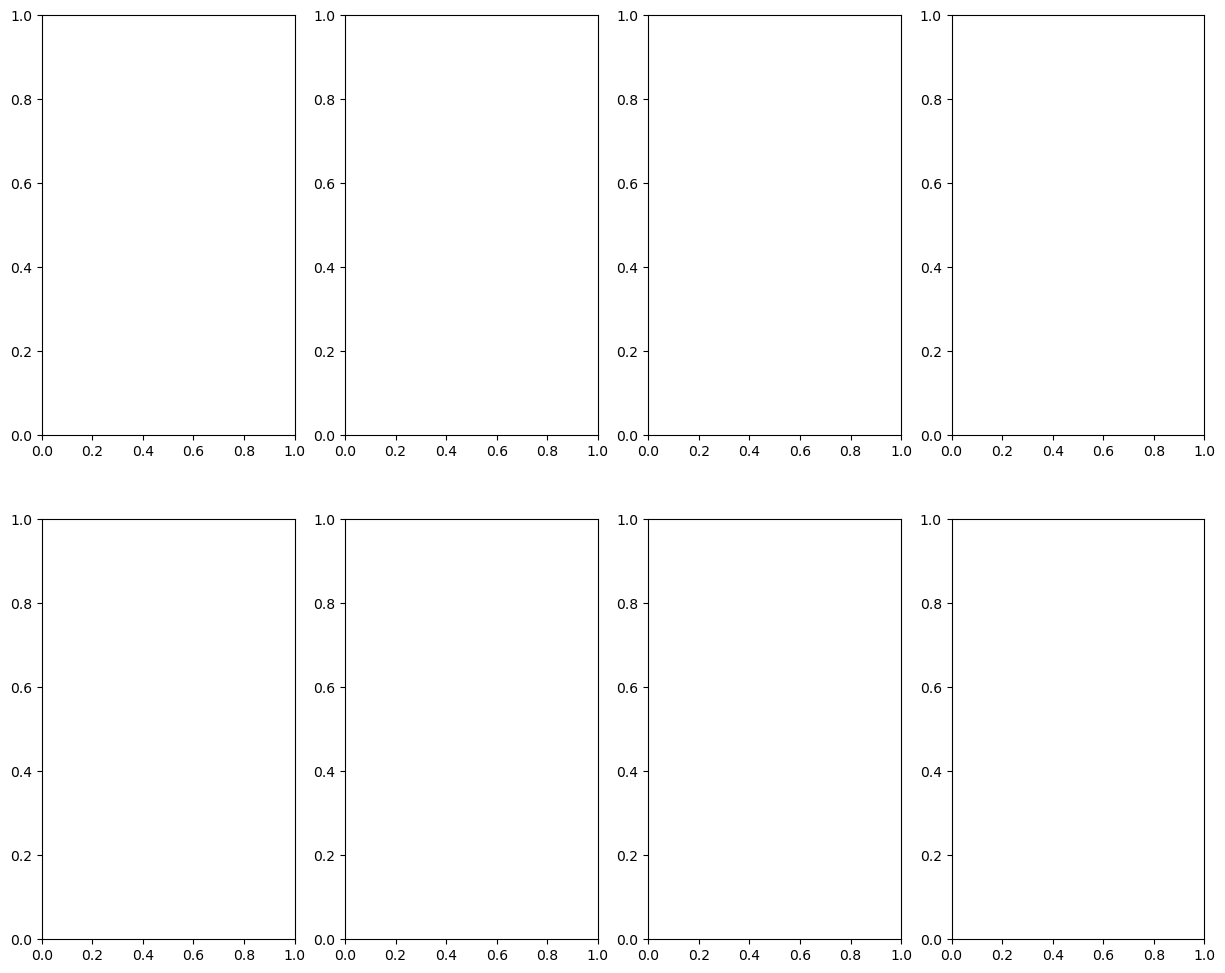

In [10]:
# first column original units (kgC/m2)
# total carbon units (sum of all carbon, not per m2)

unitconvert=PgperKg
# zonal mean shaded plot, one plot for each model

# loop over models
for m in range(len(modellist)):
    model=modellist[m]
    print('Plotting ' +model)

    mcolor=modelcolors[m]

    # Create a figure and axis objects
    num_rows=2
    fig, axs = plt.subplots(num_rows, 4, figsize=(15, num_rows * 6))
    
    # these will be loaded right here
    ds0g=load_one_model_onevar(model,runlist_wc[0],'cVeg')

    ###---- grid info
    lat = ds0g.lat

    #--- get area and land fraction
    ds_area = data_dict[modellist[m] +'_' +'areacella']
    ds_landfrac = data_dict[modellist[m] +'_' +'landfrac']
    
    if model=='CESM2':
        area = ds_area['areacella'].squeeze().reindex_like(ds0g, method='nearest',tolerance=0.05)
    else:
        area = ds_area['areacella'].reindex_like(ds0g, method='nearest',tolerance=0.05)
    
    landfrac=ds_landfrac['sftlf'].reindex_like(ds0g, method='nearest',tolerance=0.05)
    
    if landfrac.max(dim=['lat','lon'])>1: #test if landfrac is on a 0-100 or 0-1 scale
        landfrac=landfrac/100

    landarea=(area*landfrac)
    area_per_lat_m2=(area*landfrac).sum(dim='lon')

    
    # ds0g = data_dict[modellist[m] +'_' +runlist[0]] #flat10
    # ds1g = data_dict[modellist[m] +'_' +runlist[1]] #flat10-zec
    # ds2g = data_dict[modellist[m] +'_' +runlist[2]] #flat10-cdr
    

        
    

    ## - convert data to zonal means here
    # ds0=ds0g.mean(dim='lon')
    # ds1=ds2g.mean(dim='lon')
    # ds2=ds2g.mean(dim='lon')
        
    

    #----###-----####----- cVeg
    var='cVeg'
    ds=load_one_model_onevar(model,runlist_wc[0],var) #load one model one experiment one var
    ds0=ds.mean(dim='lon') # zonal mean
    dsw=weighted_temporal_mean(ds0,var) # annual mean    
    del ds # drop full grid from memory   
    dst= select_time_slice(dsw, 0, 9) # first ten years of flat10
    dsften_cVeg = dst.mean(dim='time') # original units
    dsften_cVeg_PgC = unitconvert*(dst*landarea).sum(dim='lon').mean(dim='time') # converted to PgC
    dst=select_time_slice(dsw, 90, 99) # last ten years of flat10
    dslten0_cVeg = dst.mean(dim='time') # original units
    dslten0_cVeg_PgC = unitconvert*(dst*landarea).sum(dim='lon').mean(dim='time')# converted to PgC

    ds=load_one_model_onevar(model,runlist_wc[1],var) #load one model one experiment one var
    ds1=ds.mean(dim='lon') # zonal mean
    dsw=weighted_temporal_mean(ds1,var)
    del ds # drop full grid from memory
    dst = select_time_slice(dsw, 190, 199) #last ten years of flat10-zec
    dslten1_cVeg = dst.mean(dim='time') # original units
    dslten1_cVeg_PgC = unitconvert*(dst*landarea).sum(dim='lon').mean(dim='time')# converted to PgC

    ds=load_one_model_onevar(model,runlist_wc[2],var) #load one model one experiment one var
    ds2=ds.mean(dim='lon') # zonal mean
    dsw=weighted_temporal_mean(ds2,var)
    del ds # drop full grid from memory
    dst = select_time_slice(dsw, 190, 199) # last ten years of flat10-cdr
    dslten2_cVeg = dst.mean(dim='time') # original units
    dslten2_cVeg_PgC = unitconvert*(dst*landarea).sum(dim='lon').mean(dim='time')# converted to PgC


    #----###-----####----- cSoil
    var='cSoil'
    ds=load_one_model_onevar(model,runlist_wc[0],var) #load one model one experiment one var
    ds0=ds.mean(dim='lon') # zonal mean
    dsw=weighted_temporal_mean(ds0,var) # annual mean    
    del ds # drop full grid from memory   
    dst= select_time_slice(dsw, 0, 9) # first ten years of flat10
    dsften_cSoil = dst.mean(dim='time') # original units
    dsften_cSoil_PgC = unitconvert*(dst*landarea).sum(dim='lon').mean(dim='time') # converted to PgC
    dst=select_time_slice(dsw, 90, 99) # last ten years of flat10
    dslten0_cSoil = dst.mean(dim='time') # original units
    dslten0_cSoil_PgC = unitconvert*(dst*landarea).sum(dim='lon').mean(dim='time')# converted to PgC

    ds=load_one_model_onevar(model,runlist_wc[1],var) #load one model one experiment one var
    ds1=ds.mean(dim='lon') # zonal mean
    dsw=weighted_temporal_mean(ds1,var)
    del ds # drop full grid from memory
    dst = select_time_slice(dsw, 190, 199) #last ten years of flat10-zec
    dslten1_cSoil = dst.mean(dim='time') # original units
    dslten1_cSoil_PgC = unitconvert*(dst*landarea).sum(dim='lon').mean(dim='time')# converted to PgC

    ds=load_one_model_onevar(model,runlist_wc[2],var) #load one model one experiment one var
    ds2=ds.mean(dim='lon') # zonal mean
    dsw=weighted_temporal_mean(ds2,var)
    del ds # drop full grid from memory
    dst = select_time_slice(dsw, 190, 199) # last ten years of flat10-cdr
    dslten2_cSoil = dst.mean(dim='time') # original units
    dslten2_cSoil_PgC = unitconvert*(dst*landarea).sum(dim='lon').mean(dim='time')# converted to PgC


    #----###-----####----- cLitter
    var='cLitter'
    ds=load_one_model_onevar(model,runlist_wc[0],var) #load one model one experiment one var
    if ds is not None:
        ds0=ds.mean(dim='lon') # zonal mean
        dsw=weighted_temporal_mean(ds0,var) # annual mean    
        del ds # drop full grid from memory   
        dst= select_time_slice(dsw, 0, 9) # first ten years of flat10
        dsften_cLitter = dst.mean(dim='time') # original units
        dsften_cLitter_PgC = unitconvert*(dst*landarea).sum(dim='lon').mean(dim='time') # converted to PgC
        dst=select_time_slice(dsw, 90, 99) # last ten years of flat10
        dslten0_cLitter = dst.mean(dim='time') # original units
        dslten0_cLitter_PgC = unitconvert*(dst*landarea).sum(dim='lon').mean(dim='time')# converted to PgC
    
        ds=load_one_model_onevar(model,runlist_wc[1],var) #load one model one experiment one var
        ds1=ds.mean(dim='lon') # zonal mean
        dsw=weighted_temporal_mean(ds1,var)
        del ds # drop full grid from memory
        dst = select_time_slice(dsw, 190, 199) #last ten years of flat10-zec
        dslten1_cLitter = dst.mean(dim='time') # original units
        dslten1_cLitter_PgC = unitconvert*(dst*landarea).sum(dim='lon').mean(dim='time')# converted to PgC
    
        ds=load_one_model_onevar(model,runlist_wc[2],var) #load one model one experiment one var
        ds2=ds.mean(dim='lon') # zonal mean
        dsw=weighted_temporal_mean(ds2,var)
        del ds # drop full grid from memory
        dst = select_time_slice(dsw, 190, 199) # last ten years of flat10-cdr
        dslten2_cLitter = dst .mean(dim='time') # original units
        dslten2_cLitter_PgC = unitconvert*(dst*landarea).sum(dim='lon').mean(dim='time')# converted to PgC
    
    
        #----###-----####----- cTot
        # derived variable, sum of Veg, Soil, Litter
        # var='cTot'
        dsften_cTot = dsften_cVeg + dsften_cSoil + dsften_cLitter
        dsften_cTot_PgC = dsften_cVeg_PgC + dsften_cSoil_PgC + dsften_cLitter_PgC
        dslten0_cTot = dslten0_cVeg + dslten0_cSoil + dslten0_cLitter
        dslten0_cTot_PgC = dslten0_cVeg_PgC + dslten0_cSoil_PgC + dslten0_cLitter_PgC
        dslten1_cTot = dslten1_cVeg + dslten1_cSoil + dslten1_cLitter
        dslten1_cTot_PgC = dslten1_cVeg_PgC + dslten1_cSoil_PgC + dslten1_cLitter_PgC
        dslten2_cTot = dslten2_cVeg + dslten2_cSoil + dslten2_cLitter
        dslten2_cTot_PgC = dslten2_cVeg_PgC + dslten2_cSoil_PgC + dslten2_cLitter_PgC

    else: # litter variable doesn't exist
        #----###-----####----- cTot
        # derived variable, sum of Veg, Soil, but NOT litter
        # var='cTot'
        dsften_cTot = dsften_cVeg + dsften_cSoil
        dsften_cTot_PgC = dsften_cVeg_PgC + dsften_cSoil_PgC
        dslten0_cTot = dslten0_cVeg + dslten0_cSoil 
        dslten0_cTot_PgC = dslten0_cVeg_PgC + dslten0_cSoil_PgC 
        dslten1_cTot = dslten1_cVeg + dslten1_cSoil 
        dslten1_cTot_PgC = dslten1_cVeg_PgC + dslten1_cSoil_PgC 
        dslten2_cTot = dslten2_cVeg + dslten2_cSoil 
        dslten2_cTot_PgC = dslten2_cVeg_PgC + dslten2_cSoil_PgC 
    
    # ds=load_one_model_onevar(model,runlist_wc[0],var) #load one model one experiment one var
    # ds0=ds.mean(dim='lon') # zonal mean
    # dsw=weighted_temporal_mean(ds0,var) # annual mean    
    # del ds # drop full grid from memory   
    # dst= select_time_slice(dsw, 0, 9) # first ten years of flat10
    # dsften_cTot = dst.mean(dim='time') # original units
    # dsften_cTot_PgC = unitconvert*(dst*landarea).sum(dim='lon').mean(dim='time') # converted to PgC
    # dst=select_time_slice(dsw, 90, 99) # last ten years of flat10
    # dslten0_cTot = dst.mean(dim='time') # original units
    # dslten0_cTot_PgC = unitconvert*(dst*landarea).sum(dim='lon').mean(dim='time')# converted to PgC

    # ds=load_one_model_onevar(model,runlist_wc[1],var) #load one model one experiment one var
    # ds1=ds.mean(dim='lon') # zonal mean
    # dsw=weighted_temporal_mean(ds1,var)
    # del ds # drop full grid from memory
    # dst = select_time_slice(dsw, 190, 199) #last ten years of flat10-zec
    # dslten1_cTot = dst.mean(dim='time') # original units
    # dslten1_cTot_PgC = unitconvert*(dst*landarea).sum(dim='lon').mean(dim='time')# converted to PgC

    # ds=load_one_model_onevar(model,runlist_wc[2],var) #load one model one experiment one var
    # ds2=ds.mean(dim='lon') # zonal mean
    # dsw=weighted_temporal_mean(ds2,var)
    # del ds # drop full grid from memory
    # dst = select_time_slice(dsw, 190, 199) # last ten years of flat10-cdr
    # dslten2_cTot = dst.mean(dim='lon').mean(dim='time') # original units
    # dslten2_cTot_PgC = unitconvert*(dst*landarea).sum(dim='lon').mean(dim='time')# converted to PgC



    #  drop some things from memory
    del ds0, ds1, ds2
    
    ###----------------------Plot-------------------------###

    # to use, refer to one index in axs: ax = axs[row, column]

    #--------------------------First row is per m2 units (original units)
    #---First column is flat10 climatology
    #--- first column is the climatology, or average of first 10 years 
    ax = axs[0,0] 

    # plot lines soil, veg + soil, total-litter, total
#    dsften_cTot.plot(ax=ax,y='lat', linestyle='-',color=mcolor,label='Total')
#    dsften_cSoil.plot(ax=ax,y='lat', linestyle='--',color=mcolor,label='_nolabel_')
#    (dsften_cVeg+dsften_cSoil).plot(ax=ax,y='lat', linestyle='-.',color=mcolor,label='_nolabel_')
    #(dsften_cTot-dsften_cLitter).mean(dim='time').plot(ax=ax,y='lat',label=model, linestyle='.-',color=mcolor)

    ax.plot(dsften_cTot,lat, linestyle='-',color=mcolor,label='Total')
    ax.plot(dsften_cSoil,lat, linestyle='--',color=mcolor,label='_nolabel_')
    ax.plot((dsften_cVeg+dsften_cSoil),lat, linestyle='-.',color=mcolor,label='_nolabel_')

    # plot shaded area
    # soil, soil to veg
    #ax.fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
    fg = ax.fill_betweenx(lat,0, dsften_cSoil,alpha=0.8,color=mcolor,label='Soil')
    fg2 = ax.fill_betweenx(lat,dsften_cSoil,dsften_cSoil+dsften_cVeg,alpha=0.3,color=mcolor,label='Veg',hatch='//',edgecolor='black')


    #--- Second column is end of flat10 emissions phase
    # this is last 10 of flat10 minus the first ten of flat10
    ax = axs[0,1]  
    #dsdelta=(dslten0.mean(dim='time')-dsften.mean(dim='time')).mean(dim='lon') #last 10 years of flat10 minus first ten years of flat10-zec
    #.plot(ax=ax,y='lat',label=model, linestyle='-',color=mcolor)


    # plot lines soil, veg + soil, total-litter, total
    (dslten0_cTot-dsften_cTot).plot(ax=ax,y='lat', linestyle='-',color=mcolor,label='Total')
    (dslten0_cSoil-dsften_cSoil).plot(ax=ax,y='lat', linestyle='--',color=mcolor,label='_nolabel_')
    ((dslten0_cVeg+dslten0_cSoil)-(dsften_cVeg+dsften_cSoil)).plot(ax=ax,y='lat', linestyle='-.',color=mcolor,label='_nolabel_')
    #(dsften_cTot-dsften_cLitter).mean(dim='time').plot(ax=ax,y='lat',label=model, linestyle='.-',color=mcolor)

    # plot shaded area
    # soil, soil to veg
    #ax.fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
    fg = ax.fill_betweenx(lat,0, dslten0_cSoil-dsften_cSoil,alpha=0.8,color=mcolor,label='Soil')
    fg2 = ax.fill_betweenx(lat,dslten0_cSoil-dsften_cSoil,(dslten0_cSoil-dsften_cSoil)+(dslten0_cVeg-dsften_cVeg),alpha=0.3,color=mcolor,label='Veg',hatch='//',edgecolor='black')
        
    #--- Third column is end of flat10zec phase
    # this is the last 10 of flat10zec minus the last 10 of flat10
    ax = axs[0,2] 
    #dsdelta=dslten1.mean(dim='time')-dslten0.mean(dim='time') #last 10 years of flat10-zec minus last 10 years of flat10
    #fg = dsdelta.mean(dim='lon').plot(ax=ax,y='lat',label=model, linestyle='-',color=mcolor) 

    # plot lines soil, veg + soil, total-litter, total
    (dslten1_cTot-dslten0_cTot).plot(ax=ax,y='lat', linestyle='-',color=mcolor,label='Total')
    (dslten1_cSoil-dslten0_cSoil).plot(ax=ax,y='lat', linestyle='--',color=mcolor,label='_nolabel_')
    ((dslten1_cVeg+dslten1_cSoil)-(dslten0_cVeg+dslten0_cSoil)).plot(ax=ax,y='lat', linestyle='-.',color=mcolor,label='_nolabel_')
    #(dsften_cTot-dsften_cLitter).mean(dim='time').plot(ax=ax,y='lat',label=model, linestyle='.-',color=mcolor)

    # plot shaded area
    # soil, soil to veg
    #ax.fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
    fg = ax.fill_betweenx(lat,0, dslten1_cSoil-dslten0_cSoil,alpha=0.8,color=mcolor,label='Soil')
    fg2 = ax.fill_betweenx(lat,dslten1_cSoil-dslten0_cSoil,(dslten1_cSoil-dslten0_cSoil)+(dslten1_cVeg-dslten0_cVeg),alpha=0.3,color=mcolor,label='Veg',hatch='//',edgecolor='black')

    #--- Fourth column is end of flat10cdr phase
    # this is the last 10 of flat10cdr minus the first ten of flat10

    ax = axs[0,3] 

    #dsdelta=dslten2.mean(dim='time')-dsften.mean(dim='time') #last 10 years of flat10-cdr minus first ten years of flat10
    #fg = dsdelta.mean(dim='lon').plot(ax=ax,y='lat',label=model, linestyle='-',color=mcolor) 


    # plot lines soil, veg + soil, total-litter, total
    (dslten2_cTot-dsften_cTot).plot(ax=ax,y='lat', linestyle='-',color=mcolor,label='Total')
    (dslten2_cSoil-dsften_cSoil).plot(ax=ax,y='lat', linestyle='--',color=mcolor,label='_nolabel_')
    ((dslten2_cVeg+dslten2_cSoil)-(dsften_cVeg+dsften_cSoil)).plot(ax=ax,y='lat', linestyle='-.',color=mcolor,label='_nolabel_')
    #(dsften_cTot-dsften_cLitter).mean(dim='time').plot(ax=ax,y='lat',label=model, linestyle='.-',color=mcolor)
    
    # plot shaded area
    # soil, soil to veg
    #ax.fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
    fg = ax.fill_betweenx(lat,0, dslten2_cSoil-dsften_cSoil,alpha=0.8,color=mcolor,label='Soil')
    fg2 = ax.fill_betweenx(lat,dslten2_cSoil-dsften_cSoil,(dslten2_cSoil-dsften_cSoil)+(dslten2_cVeg-dsften_cVeg),alpha=0.3,color=mcolor,label='Veg',hatch='//',edgecolor='black')


    #-- try setting some properties after the loop through models
    ax=axs[0,0]
    ax.set_ylim([-90, 90])
    ax.grid(True)
    ax.set_ylabel(model)
    ax.set_xlabel('kgC/m2')
    ax.legend()
    
    ax=axs[0,1]
    ax.set_ylim([-90, 90])
    ax.grid(True)
    ax.set_xlabel('kgC/m2')
    ax.set_ylabel('')
    
    ax=axs[0,2]
    ax.set_ylim([-90, 90])
    ax.grid(True)
    ax.set_xlabel('kgC/m2')
    ax.set_ylabel('')
    
    ax=axs[0,3]
    ax.set_ylim([-90, 90])
    ax.grid(True)
    ax.set_xlabel('kgC/m2')
    ax.set_ylabel('')
    

    # set titles for top row of plots
    ax=axs[0,0]
    ax.set_title('initial state \n beginning of flat10')
    
    ax=axs[0,1]
    ax.set_title('carbon gained during emissions phase \n end of flat10 - beginning of flat10')
    
    ax=axs[0,2]
    ax.set_title('carbon change after net-zero \n end of flat10zec - end of flat10')
    
    ax=axs[0,3]
    ax.set_title('carbon reversibility \n end of flat10cdr - beginning of flat10')
    
    #--------------------------Second row is per m2 units (original units)
    #---First column is flat10 climatology
    #--- first column is the climatology, or average of first 10 years 
    ax = axs[1,0] 

    # plot lines soil, veg + soil, total-litter, total
#    dsften_cTot.plot(ax=ax,y='lat', linestyle='-',color=mcolor,label='Total')
#    dsften_cSoil.plot(ax=ax,y='lat', linestyle='--',color=mcolor,label='_nolabel_')
#    (dsften_cVeg+dsften_cSoil).plot(ax=ax,y='lat', linestyle='-.',color=mcolor,label='_nolabel_')
    #(dsften_cTot-dsften_cLitter).mean(dim='time').plot(ax=ax,y='lat',label=model, linestyle='.-',color=mcolor)

    ax.plot(dsften_cTot_PgC,lat, linestyle='-',color=mcolor,label='Total')
    ax.plot(dsften_cSoil_PgC,lat, linestyle='--',color=mcolor,label='_nolabel_')
    ax.plot((dsften_cVeg_PgC+dsften_cSoil_PgC),lat, linestyle='-.',color=mcolor,label='_nolabel_')

    # plot shaded area
    # soil, soil to veg
    #ax.fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
    fg = ax.fill_betweenx(lat,0, dsften_cSoil_PgC,alpha=0.8,color=mcolor,label='Soil')
    fg2 = ax.fill_betweenx(lat,dsften_cSoil_PgC,dsften_cSoil_PgC+dsften_cVeg_PgC,alpha=0.3,color=mcolor,label='Veg',hatch='//',edgecolor='black')


    #--- Second column is end of flat10 emissions phase
    ax = axs[1,1]  
    #dsdelta=(dslten0.mean(dim='time')-dsften.mean(dim='time')).mean(dim='lon') #last 10 years of flat10 minus first ten years of flat10-zec
    #.plot(ax=ax,y='lat',label=model, linestyle='-',color=mcolor)


    # plot lines soil, veg + soil, total-litter, total
    (dslten0_cTot_PgC-dsften_cTot_PgC).plot(ax=ax,y='lat', linestyle='-',color=mcolor,label='Total')
    (dslten0_cSoil_PgC-dsften_cSoil_PgC).plot(ax=ax,y='lat', linestyle='--',color=mcolor,label='_nolabel_')
    ((dslten0_cVeg_PgC+dslten0_cSoil_PgC)-(dsften_cVeg_PgC+dsften_cSoil_PgC)).plot(ax=ax,y='lat', linestyle='-.',color=mcolor,label='_nolabel_')
    #(dsften_cTot-dsften_cLitter).mean(dim='time').plot(ax=ax,y='lat',label=model, linestyle='.-',color=mcolor)

    # plot shaded area
    # soil, soil to veg
    #ax.fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
    fg = ax.fill_betweenx(lat,0, dslten0_cSoil_PgC-dsften_cSoil_PgC,alpha=0.8,color=mcolor,label='Soil')
    fg2 = ax.fill_betweenx(lat,dslten0_cSoil_PgC-dsften_cSoil_PgC,(dslten0_cSoil_PgC-dsften_cSoil_PgC)+(dslten0_cVeg_PgC-dsften_cVeg_PgC),alpha=0.3,color=mcolor,label='Veg',hatch='//',edgecolor='black')

    #--- Third column is end of flat10zec phase
    ax = axs[1,2] 
    #dsdelta=dslten1.mean(dim='time')-dslten0.mean(dim='time') #last 10 years of flat10-zec minus last 10 years of flat10
    #fg = dsdelta.mean(dim='lon').plot(ax=ax,y='lat',label=model, linestyle='-',color=mcolor) 

    # plot lines soil, veg + soil, total-litter, total
    (dslten1_cTot_PgC-dslten0_cTot_PgC).plot(ax=ax,y='lat', linestyle='-',color=mcolor,label='Total')
    (dslten1_cSoil_PgC-dslten0_cSoil_PgC).plot(ax=ax,y='lat', linestyle='--',color=mcolor,label='_nolabel_')
    ((dslten1_cVeg_PgC+dslten1_cSoil_PgC)-(dslten0_cVeg_PgC+dslten0_cSoil_PgC)).plot(ax=ax,y='lat', linestyle='-.',color=mcolor,label='_nolabel_')
    #(dsften_cTot-dsften_cLitter).mean(dim='time').plot(ax=ax,y='lat',label=model, linestyle='.-',color=mcolor)

    # plot shaded area
    # soil, soil to veg
    #ax.fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
    fg = ax.fill_betweenx(lat,0, dslten1_cSoil_PgC-dslten0_cSoil_PgC,alpha=0.8,color=mcolor,label='Soil')
    fg2 = ax.fill_betweenx(lat,dslten1_cSoil_PgC-dslten0_cSoil_PgC,(dslten1_cSoil_PgC-dslten0_cSoil_PgC)+(dslten1_cVeg_PgC-dslten0_cVeg_PgC),alpha=0.3,color=mcolor,label='Veg',hatch='//',edgecolor='black')

    #--- Fourth column is end of flat10cdr phase

    ax = axs[1,3] 

    #dsdelta=dslten2.mean(dim='time')-dsften.mean(dim='time') #last 10 years of flat10-cdr minus first ten years of flat10
    #fg = dsdelta.mean(dim='lon').plot(ax=ax,y='lat',label=model, linestyle='-',color=mcolor) 


    # plot lines soil, veg + soil, total-litter, total
    (dslten2_cTot_PgC-dsften_cTot_PgC).plot(ax=ax,y='lat', linestyle='-',color=mcolor,label='Total')
    (dslten2_cSoil_PgC-dsften_cSoil_PgC).plot(ax=ax,y='lat', linestyle='--',color=mcolor,label='_nolabel_')
    ((dslten2_cVeg_PgC+dslten2_cSoil_PgC)-(dsften_cVeg_PgC+dsften_cSoil_PgC)).plot(ax=ax,y='lat', linestyle='-.',color=mcolor,label='_nolabel_')
    #(dsften_cTot-dsften_cLitter).mean(dim='time').plot(ax=ax,y='lat',label=model, linestyle='.-',color=mcolor)
    
    # plot shaded area
    # soil, soil to veg
    #ax.fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
    fg = ax.fill_betweenx(lat,0, dslten2_cSoil_PgC-dsften_cSoil_PgC,alpha=0.8,color=mcolor,label='Soil')
    fg2 = ax.fill_betweenx(lat,dslten2_cSoil_PgC-dsften_cSoil_PgC,(dslten2_cSoil_PgC-dsften_cSoil_PgC)+(dslten2_cVeg_PgC-dsften_cVeg_PgC),alpha=0.3,color=mcolor,label='Veg',hatch='//',edgecolor='black')


    #-- try setting some properties after the loop through models
    ax=axs[1,0]
    ax.set_ylim([-90, 90])
    ax.grid(True)
    ax.set_ylabel(model)
    ax.set_xlabel('PgC')
    ax.legend()
    
    ax=axs[1,1]
    ax.set_ylim([-90, 90])
    ax.grid(True)
    ax.set_xlabel('PgC')
    ax.set_ylabel('')
    
    ax=axs[1,2]
    ax.set_ylim([-90, 90])
    ax.grid(True)
    ax.set_xlabel('PgC')
    ax.set_ylabel('')
    
    ax=axs[1,3]
    ax.set_ylim([-90, 90])
    ax.grid(True)
    ax.set_xlabel('PgC')
    ax.set_ylabel('')
    

    # set titles for top row of plots
    ax=axs[1,0]
    ax.set_title('initial state \n beginning of flat10')
    
    ax=axs[1,1]
    ax.set_title('carbon gained during emissions phase \n end of flat10 - beginning of flat10')
    
    ax=axs[1,2]
    ax.set_title('carbon change after net-zero \n end of flat10zec - end of flat10')
    
    ax=axs[1,3]
    ax.set_title('carbon reversibility \n end of flat10cdr - beginning of flat10')
    
    
    # show the plot:
    plt.show()
    
    # save the plot
    fig.savefig('figures/' +'Cdelta_zonal_lineplot_' +model +'_both.png', bbox_inches='tight', dpi=400)
    fig.savefig('figures/' +'Cdelta_zonal_lineplot_' +model +'_both.png', bbox_inches='tight')
    
    print('done saving file')
    
    # close the plot (so python stops trying to hold on to it in memory; you can
    # still look at it at this point, but you're done editing)
    plt.close()


# all changes for one model in a row grouped into one figure

In [ ]:
# first column original units (kgC/m2)
# total carbon units (sum of all carbon, not per m2)

phasename=['InitialC','EmissionsPhase','NetZero','CumulativeZero']

num_rows=len(modellist)
num_cols=4
fig0, axes = plt.subplots(num_rows,num_cols,figsize=(3.75 * num_cols, num_rows * 6 )) # initial C
# fig1, axes1 = plt.subplots(num_rows,num_cols,figsize=(3.75 * num_cols, num_rows * 6 )) # emissions phase
# fig2, axes2 = plt.subplots(num_rows,num_cols,figsize=(3.75 * num_cols, num_rows * 6 )) # net zero
# fig3, axes3 = plt.subplots(num_rows,num_cols,figsize=(3.75 * num_cols, num_rows * 6 )) # cumulative zero

# axes=axes0.flatten()
# axes1=axes1.flatten()
# axes2=axes2.flatten()
# axes3=axes3.flatten()


unitconvert=PgperKg
# zonal mean shaded plot, one plot for each model

# loop over models
for m in range(len(modellist)):
    model=modellist[m]
    print('Plotting ' +model)

    mcolor=modelcolors[m]

    # these will be loaded right here
    ds0g=load_one_model_onevar(model,runlist_wc[0],'cVeg')

    ###---- grid info
    lat = ds0g.lat

    #--- get area and land fraction
    ds_area = data_dict[modellist[m] +'_' +'areacella']
    ds_landfrac = data_dict[modellist[m] +'_' +'landfrac']
    
    if model=='CESM2':
        area = ds_area['areacella'].squeeze().reindex_like(ds0g, method='nearest',tolerance=0.05)
    else:
        area = ds_area['areacella'].reindex_like(ds0g, method='nearest',tolerance=0.05)
    
    landfrac=ds_landfrac['sftlf'].reindex_like(ds0g, method='nearest',tolerance=0.05)
    
    if landfrac.max(dim=['lat','lon'])>1: #test if landfrac is on a 0-100 or 0-1 scale
        landfrac=landfrac/100

    landarea=(area*landfrac)
    area_per_lat_m2=(area*landfrac).sum(dim='lon')

    #----###-----####----- cVeg
    var='cVeg'
    ds0=load_one_model_onevar(model,runlist_wc[0],var) #load one model one experiment one var
    # ds0=ds.mean(dim='lon') # zonal mean
    dsw=weighted_temporal_mean(ds0,var) # annual mean    
    # del ds # drop full grid from memory   
    dst= select_time_slice(dsw, 0, 9) # first ten years of flat10
    dsften_cVeg = dst.mean(dim='time').mean(dim='lon') # original units
    dsften_cVeg_PgC = unitconvert*(dst*landarea).sum(dim='lon').mean(dim='time') # converted to PgC
    dst=select_time_slice(dsw, 90, 99) # last ten years of flat10
    dslten0_cVeg = dst.mean(dim='time').mean(dim='lon') # original units
    dslten0_cVeg_PgC = unitconvert*(dst*landarea).sum(dim='lon').mean(dim='time')# converted to PgC

    ds1=load_one_model_onevar(model,runlist_wc[1],var) #load one model one experiment one var
    # ds1=ds.mean(dim='lon') # zonal mean
    dsw=weighted_temporal_mean(ds1,var)
    # del ds # drop full grid from memory
    dst = select_time_slice(dsw, 190, 199) #last ten years of flat10-zec
    dslten1_cVeg = dst.mean(dim='time').mean(dim='lon') # original units
    dslten1_cVeg_PgC = unitconvert*(dst*landarea).sum(dim='lon').mean(dim='time')# converted to PgC

    ds2=load_one_model_onevar(model,runlist_wc[2],var) #load one model one experiment one var
    # ds2=ds.mean(dim='lon') # zonal mean
    dsw=weighted_temporal_mean(ds2,var)
    # del ds # drop full grid from memory
    dst = select_time_slice(dsw, 190, 199) # last ten years of flat10-cdr
    dslten2_cVeg = dst.mean(dim='time').mean(dim='lon') # original units
    dslten2_cVeg_PgC = unitconvert*(dst*landarea).sum(dim='lon').mean(dim='time')# converted to PgC


    #----###-----####----- cSoil
    var='cSoil'
    ds0=load_one_model_onevar(model,runlist_wc[0],var) #load one model one experiment one var
    # ds0=ds.mean(dim='lon') # zonal mean
    dsw=weighted_temporal_mean(ds0,var) # annual mean    
    # del ds # drop full grid from memory   
    dst= select_time_slice(dsw, 0, 9) # first ten years of flat10
    dsften_cSoil = dst.mean(dim='time').mean(dim='lon') # original units
    dsften_cSoil_PgC = unitconvert*(dst*landarea).sum(dim='lon').mean(dim='time') # converted to PgC
    dst=select_time_slice(dsw, 90, 99) # last ten years of flat10
    dslten0_cSoil = dst.mean(dim='time').mean(dim='lon') # original units
    dslten0_cSoil_PgC = unitconvert*(dst*landarea).sum(dim='lon').mean(dim='time')# converted to PgC

    ds1=load_one_model_onevar(model,runlist_wc[1],var) #load one model one experiment one var
    # ds1=ds.mean(dim='lon') # zonal mean
    dsw=weighted_temporal_mean(ds1,var)
    # del ds # drop full grid from memory
    dst = select_time_slice(dsw, 190, 199) #last ten years of flat10-zec
    dslten1_cSoil = dst.mean(dim='time').mean(dim='lon') # original units
    dslten1_cSoil_PgC = unitconvert*(dst*landarea).sum(dim='lon').mean(dim='time')# converted to PgC

    ds2=load_one_model_onevar(model,runlist_wc[2],var) #load one model one experiment one var
    # ds2=ds.mean(dim='lon') # zonal mean
    dsw=weighted_temporal_mean(ds2,var)
    # del ds # drop full grid from memory
    dst = select_time_slice(dsw, 190, 199) # last ten years of flat10-cdr
    dslten2_cSoil = dst.mean(dim='time').mean(dim='lon') # original units
    dslten2_cSoil_PgC = unitconvert*(dst*landarea).sum(dim='lon').mean(dim='time')# converted to PgC


    #----###-----####----- cLitter
    var='cLitter'
    ds0=load_one_model_onevar(model,runlist_wc[0],var) #load one model one experiment one var
    if ds0 is not None:
        # ds0=ds.mean(dim='lon') # zonal mean
        dsw=weighted_temporal_mean(ds0,var) # annual mean    
        # del ds # drop full grid from memory   
        dst= select_time_slice(dsw, 0, 9) # first ten years of flat10
        dsften_cLitter = dst.mean(dim='time').mean(dim='lon') # original units
        dsften_cLitter_PgC = unitconvert*(dst*landarea).sum(dim='lon').mean(dim='time') # converted to PgC
        dst=select_time_slice(dsw, 90, 99) # last ten years of flat10
        dslten0_cLitter = dst.mean(dim='time').mean(dim='lon') # original units
        dslten0_cLitter_PgC = unitconvert*(dst*landarea).sum(dim='lon').mean(dim='time')# converted to PgC
    
        ds1=load_one_model_onevar(model,runlist_wc[1],var) #load one model one experiment one var
        # ds1=ds.mean(dim='lon') # zonal mean
        dsw=weighted_temporal_mean(ds1,var)
        # del ds # drop full grid from memory
        dst = select_time_slice(dsw, 190, 199) #last ten years of flat10-zec
        dslten1_cLitter = dst.mean(dim='time').mean(dim='lon') # original units
        dslten1_cLitter_PgC = unitconvert*(dst*landarea).sum(dim='lon').mean(dim='time')# converted to PgC
    
        ds2=load_one_model_onevar(model,runlist_wc[2],var) #load one model one experiment one var
        # ds2=ds.mean(dim='lon') # zonal mean
        dsw=weighted_temporal_mean(ds2,var)
        # del ds # drop full grid from memory
        dst = select_time_slice(dsw, 190, 199) # last ten years of flat10-cdr
        dslten2_cLitter = dst .mean(dim='time').mean(dim='lon') # original units
        dslten2_cLitter_PgC = unitconvert*(dst*landarea).sum(dim='lon').mean(dim='time')# converted to PgC
    
    
        #----###-----####----- cTot
        # derived variable, sum of Veg, Soil, Litter
        # var='cTot'
        dsften_cTot = dsften_cVeg + dsften_cSoil + dsften_cLitter
        dsften_cTot_PgC = dsften_cVeg_PgC + dsften_cSoil_PgC + dsften_cLitter_PgC
        dslten0_cTot = dslten0_cVeg + dslten0_cSoil + dslten0_cLitter
        dslten0_cTot_PgC = dslten0_cVeg_PgC + dslten0_cSoil_PgC + dslten0_cLitter_PgC
        dslten1_cTot = dslten1_cVeg + dslten1_cSoil + dslten1_cLitter
        dslten1_cTot_PgC = dslten1_cVeg_PgC + dslten1_cSoil_PgC + dslten1_cLitter_PgC
        dslten2_cTot = dslten2_cVeg + dslten2_cSoil + dslten2_cLitter
        dslten2_cTot_PgC = dslten2_cVeg_PgC + dslten2_cSoil_PgC + dslten2_cLitter_PgC

    else: # litter variable doesn't exist
        #----###-----####----- cTot
        # derived variable, sum of Veg, Soil, but NOT litter
        # var='cTot'
        dsften_cTot = dsften_cVeg + dsften_cSoil
        dsften_cTot_PgC = dsften_cVeg_PgC + dsften_cSoil_PgC
        dslten0_cTot = dslten0_cVeg + dslten0_cSoil 
        dslten0_cTot_PgC = dslten0_cVeg_PgC + dslten0_cSoil_PgC 
        dslten1_cTot = dslten1_cVeg + dslten1_cSoil 
        dslten1_cTot_PgC = dslten1_cVeg_PgC + dslten1_cSoil_PgC 
        dslten2_cTot = dslten2_cVeg + dslten2_cSoil 
        dslten2_cTot_PgC = dslten2_cVeg_PgC + dslten2_cSoil_PgC 

    #  drop some things from memory
    del ds0, ds1, ds2
    
    ###----------------------Plot-------------------------###

    # to use, refer to one index in axs: ax = axs[row, column]


    #--------------------------Second row is total carbon units (PgC)
    #---First column is flat10 climatology
    #--- first figure is the climatology, or average of first 10 years 
    ax = axes[m,0]


    # plot lines soil, veg + soil, total-litter, total
#    dsften_cTot.plot(ax=ax,y='lat', linestyle='-',color=mcolor,label='Total')
#    dsften_cSoil.plot(ax=ax,y='lat', linestyle='--',color=mcolor,label='_nolabel_')
#    (dsften_cVeg+dsften_cSoil).plot(ax=ax,y='lat', linestyle='-.',color=mcolor,label='_nolabel_')
    #(dsften_cTot-dsften_cLitter).mean(dim='time').plot(ax=ax,y='lat',label=model, linestyle='.-',color=mcolor)

    ax.plot(dsften_cTot_PgC,lat, linestyle='-',color=mcolor,label='Total C')
    ax.plot(dsften_cSoil_PgC,lat, linestyle='--',color=mcolor,label='_nolabel_')
    ax.plot((dsften_cVeg_PgC+dsften_cSoil_PgC),lat, linestyle='-.',color=mcolor,label='_nolabel_')

    # plot shaded area
    # soil, soil to veg
    #ax.fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
    fg = ax.fill_betweenx(lat,0, dsften_cSoil_PgC,alpha=0.8,color=mcolor,label='Soil')
    fg2 = ax.fill_betweenx(lat,dsften_cSoil_PgC,dsften_cSoil_PgC+dsften_cVeg_PgC,alpha=0.3,color=mcolor,label='Veg',hatch='//',edgecolor='black')

    ax.set_ylim([-90, 90])
    ax.grid(True,alpha=0.2, zorder=0)
    ax.set_ylabel('Latitude',fontsize=12)
    ax.set_title(model)
    if (m!=0 and m!=num_cols): #remove y ticks for plots that are not on the left hand edge of the plot
        ax.set_yticklabels([])
        ax.set_ylabel('')
    ax.set_xlim([0, 100])

    if m>num_cols-1:
        ax.set_xlabel('[PgC]')
    ax.annotate(subplotlabelnames[m],
                         xy=(0, 1), xycoords='axes fraction',
                         xytext=(+0.5, -0.5), textcoords='offset fontsize',
                         fontsize='large', verticalalignment='top')
    
    #--- Second figure is end of flat10 emissions phase
    ax = axes0[m,1]
    #dsdelta=(dslten0.mean(dim='time')-dsften.mean(dim='time')).mean(dim='lon') #last 10 years of flat10 minus first ten years of flat10-zec
    #.plot(ax=ax,y='lat',label=model, linestyle='-',color=mcolor)
    

    # plot lines soil, veg + soil, total-litter, total
    (dslten0_cTot_PgC-dsften_cTot_PgC).plot(ax=ax,y='lat', linestyle='-',color=mcolor,label='Total C')
    (dslten0_cSoil_PgC-dsften_cSoil_PgC).plot(ax=ax,y='lat', linestyle='--',color=mcolor,label='_nolabel_')
    ((dslten0_cVeg_PgC+dslten0_cSoil_PgC)-(dsften_cVeg_PgC+dsften_cSoil_PgC)).plot(ax=ax,y='lat', linestyle='-.',color=mcolor,label='_nolabel_')
    #(dsften_cTot-dsften_cLitter).mean(dim='time').plot(ax=ax,y='lat',label=model, linestyle='.-',color=mcolor)

    # plot shaded area
    # soil, soil to veg
    #ax.fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
    fg = ax.fill_betweenx(lat,0, dslten0_cSoil_PgC-dsften_cSoil_PgC,alpha=0.8,color=mcolor,label='Soil')
    fg2 = ax.fill_betweenx(lat,dslten0_cSoil_PgC-dsften_cSoil_PgC,(dslten0_cSoil_PgC-dsften_cSoil_PgC)+(dslten0_cVeg_PgC-dsften_cVeg_PgC),alpha=0.3,color=mcolor,label='Veg',hatch='//',edgecolor='black')

    ax.set_ylim([-90, 90])
    ax.grid(True,alpha=0.2, zorder=0)
    ax.set_ylabel('Latitude',fontsize=12)
    ax.set_title(model)
    if (m!=0 and m!=num_cols): #remove y ticks for plots that are not on the left hand edge of the plot
        ax.set_yticklabels([])
        ax.set_ylabel('')

    ax.set_xlim([-1, 14])
    ax.annotate(subplotlabelnames[m],
                         xy=(0.8, 1), xycoords='axes fraction',
                         xytext=(+0.5, -0.5), textcoords='offset fontsize',
                         fontsize='large', verticalalignment='top')

    if m>num_cols-1:
        ax.set_xlabel('[PgC]')

    #--- Third figure is end of flat10zec phase
    ax = axes[m,2] 
    #dsdelta=dslten1.mean(dim='time')-dslten0.mean(dim='time') #last 10 years of flat10-zec minus last 10 years of flat10
    #fg = dsdelta.mean(dim='lon').plot(ax=ax,y='lat',label=model, linestyle='-',color=mcolor) 

    # plot lines soil, veg + soil, total-litter, total
    (dslten1_cTot_PgC-dslten0_cTot_PgC).plot(ax=ax,y='lat', linestyle='-',color=mcolor,label='Total C')
    (dslten1_cSoil_PgC-dslten0_cSoil_PgC).plot(ax=ax,y='lat', linestyle='--',color=mcolor,label='_nolabel_')
    ((dslten1_cVeg_PgC+dslten1_cSoil_PgC)-(dslten0_cVeg_PgC+dslten0_cSoil_PgC)).plot(ax=ax,y='lat', linestyle='-.',color=mcolor,label='_nolabel_')
    #(dsften_cTot-dsften_cLitter).mean(dim='time').plot(ax=ax,y='lat',label=model, linestyle='.-',color=mcolor)

    # plot shaded area
    # soil, soil to veg
    #ax.fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
    fg = ax.fill_betweenx(lat,0, dslten1_cSoil_PgC-dslten0_cSoil_PgC,alpha=0.8,color=mcolor,label='Soil')
    fg2 = ax.fill_betweenx(lat,dslten1_cSoil_PgC-dslten0_cSoil_PgC,(dslten1_cSoil_PgC-dslten0_cSoil_PgC)+(dslten1_cVeg_PgC-dslten0_cVeg_PgC),alpha=0.3,color=mcolor,label='Veg',hatch='//',edgecolor='black')

    ax.set_ylim([-90, 90])
    ax.grid(True,alpha=0.2, zorder=0)
    ax.set_ylabel('Latitude',fontsize=12)
    ax.set_title(model)
    if (m!=0 and m!=num_cols): #remove y ticks for plots that are not on the left hand edge of the plot
        ax.set_yticklabels([])
        ax.set_ylabel('')
    ax.set_xlim([-4, 6])
    ax.annotate(subplotlabelnames[m],
                         xy=(0, 1), xycoords='axes fraction',
                         xytext=(+0.5, -0.5), textcoords='offset fontsize',
                         fontsize='large', verticalalignment='top')
    
    if m>num_cols-1:
        ax.set_xlabel('[PgC]')
        
    #--- Fourth figure is end of flat10cdr phase

    ax = axes[m,3] 

    #dsdelta=dslten2.mean(dim='time')-dsften.mean(dim='time') #last 10 years of flat10-cdr minus first ten years of flat10
    #fg = dsdelta.mean(dim='lon').plot(ax=ax,y='lat',label=model, linestyle='-',color=mcolor) 


    # plot lines soil, veg + soil, total-litter, total
    (dslten2_cTot_PgC-dsften_cTot_PgC).plot(ax=ax,y='lat', linestyle='-',color=mcolor,label='Total C')
    (dslten2_cSoil_PgC-dsften_cSoil_PgC).plot(ax=ax,y='lat', linestyle='--',color=mcolor,label='_nolabel_')
    ((dslten2_cVeg_PgC+dslten2_cSoil_PgC)-(dsften_cVeg_PgC+dsften_cSoil_PgC)).plot(ax=ax,y='lat', linestyle='-.',color=mcolor,label='_nolabel_')
    #(dsften_cTot-dsften_cLitter).mean(dim='time').plot(ax=ax,y='lat',label=model, linestyle='.-',color=mcolor)
    
    # plot shaded area
    # soil, soil to veg
    #ax.fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
    fg = ax.fill_betweenx(lat,0, dslten2_cSoil_PgC-dsften_cSoil_PgC,alpha=0.8,color=mcolor,label='Soil')
    fg2 = ax.fill_betweenx(lat,dslten2_cSoil_PgC-dsften_cSoil_PgC,(dslten2_cSoil_PgC-dsften_cSoil_PgC)+(dslten2_cVeg_PgC-dsften_cVeg_PgC),alpha=0.3,color=mcolor,label='Veg',hatch='//',edgecolor='black')

    ax.set_ylim([-90, 90])
    ax.grid(True,alpha=0.2, zorder=0)
    ax.set_ylabel('Latitude',fontsize=12)
    ax.set_title(model)
    if (m!=0 and m!=num_cols): #remove y ticks for plots that are not on the left hand edge of the plot
        ax.set_yticklabels([])
        ax.set_ylabel('')
    ax.set_xlim([-4, 6])

    if m>num_cols-2:
        ax.set_xlabel('[PgC]')

    ax.annotate(subplotlabelnames[m],
                         xy=(0, 1), xycoords='axes fraction',
                         xytext=(+0.5, -0.5), textcoords='offset fontsize',
                         fontsize='large', verticalalignment='top')




# add gridlines
#axes0[m].grid(True,alpha=0.2, zorder=0)

# add legend
axes[0,0].legend(loc='lower right')
# axes1[0].legend(loc='lower right')
# axes2[0].legend(loc='lower right')
# axes3[0].legend(loc='lower right')

# # add a zonal profile of observed c pools on the ititial C plot (axes0)
# ax=axes0[9]
# cSoil, cVeg, cSoil_zonal, cVeg_zonal=load_observations(1) #load the data
# lat=cVeg_zonal.lat
# fg = ax.fill_betweenx(lat,0, cSoil_zonal.values,alpha=0.8,color=soilcolor,label='Soil')
# fg2 = ax.fill_betweenx(lat,cSoil_zonal.values, cSoil_zonal.values+cVeg_zonal.values,color=vegcolor,label='Veg',hatch='//',edgecolor='grey')
# ax.set_title('Observations')
# ax.set_ylim([-90, 90])
# ax.set_yticklabels([])
# ax.set_ylabel('')
# ax.grid(True,alpha=0.2, zorder=0)
# ax.set_xlim([0,100])
# ax.set_xlabel('[PgC]')
# ax.legend(loc='lower right')
# ax.annotate(subplotlabelnames[9],
#                          xy=(0, 1), xycoords='axes fraction',
#                          xytext=(+0.5, -0.5), textcoords='offset fontsize',
#                          fontsize='large', verticalalignment='top')

# remve the empty plot in the last slot - if we add a 10th model will need to disable this!
# # axes0[9].set_visible(False) 
# axes1[9].set_visible(False)
# axes2[9].set_visible(False) 
# axes3[9].set_visible(False)

# set title over whole plot
yh=0.92
axes[0,0].suptitle('Initial Carbon Stocks (beginning of flat10)',y=yh)
axes[0,1].suptitle('Carbon gained during emissions phase (end of flat10 - beginning of flat10)',y=yh)
axes[0,2].suptitle('Carbon change after net-zero (end of flat10zec - end of flat10)',y=yh)
axes[0,3].suptitle('Carbon change at cumulative zero emissions (end of flat10cdr - beginning of flat10)',y=yh)

# save the plot
fig0.savefig('figures/' +'Cdelta_zonal_lineplot_allmodels_allphases.png', bbox_inches='tight', dpi=400)
plt.show(fig0)
plt.close(fig0)

# fig1.savefig('figures/' +'Cdelta_zonal_lineplot_allmodels_' +phasename[1] +'.png', bbox_inches='tight', dpi=400)
# plt.show(fig1)
# plt.close(fig1)

# fig2.savefig('figures/' +'Cdelta_zonal_lineplot_allmodels_' +phasename[2] +'.png', bbox_inches='tight', dpi=400)
# plt.show(fig2)
# plt.close(fig2)

# fig3.savefig('figures/' +'Cdelta_zonal_lineplot_allmodels_' +phasename[3] +'.png', bbox_inches='tight', dpi=400)
# plt.show(fig3)
# plt.close(fig3)

print('done saving file')

# close the plot (so python stops trying to hold on to it in memory; you can
# still look at it at this point, but you're done editing)
# plt.close()


# put all models on one plot, one plot for each phase

Plotting ACCESS-ESM1-5
loading variable: cVeg
finished loading ACCESS-ESM1-5 *lat10 cVeg
loading variable: cVeg
finished loading ACCESS-ESM1-5 *lat10 cVeg
loading variable: cVeg
finished loading ACCESS-ESM1-5 *zec cVeg
loading variable: cVeg
finished loading ACCESS-ESM1-5 *cdr cVeg
loading variable: cSoil
finished loading ACCESS-ESM1-5 *lat10 cSoil
loading variable: cSoil
finished loading ACCESS-ESM1-5 *zec cSoil
loading variable: cSoil
finished loading ACCESS-ESM1-5 *cdr cSoil
loading variable: cLitter
finished loading ACCESS-ESM1-5 *lat10 cLitter
loading variable: cLitter
finished loading ACCESS-ESM1-5 *zec cLitter
loading variable: cLitter
finished loading ACCESS-ESM1-5 *cdr cLitter
Plotting CESM2
loading variable: cVeg
finished loading CESM2 *lat10 cVeg
loading variable: cVeg
finished loading CESM2 *lat10 cVeg
loading variable: cVeg
finished loading CESM2 *zec cVeg
loading variable: cVeg
finished loading CESM2 *cdr cVeg
loading variable: cSoil
finished loading CESM2 *lat10 cSoil
lo

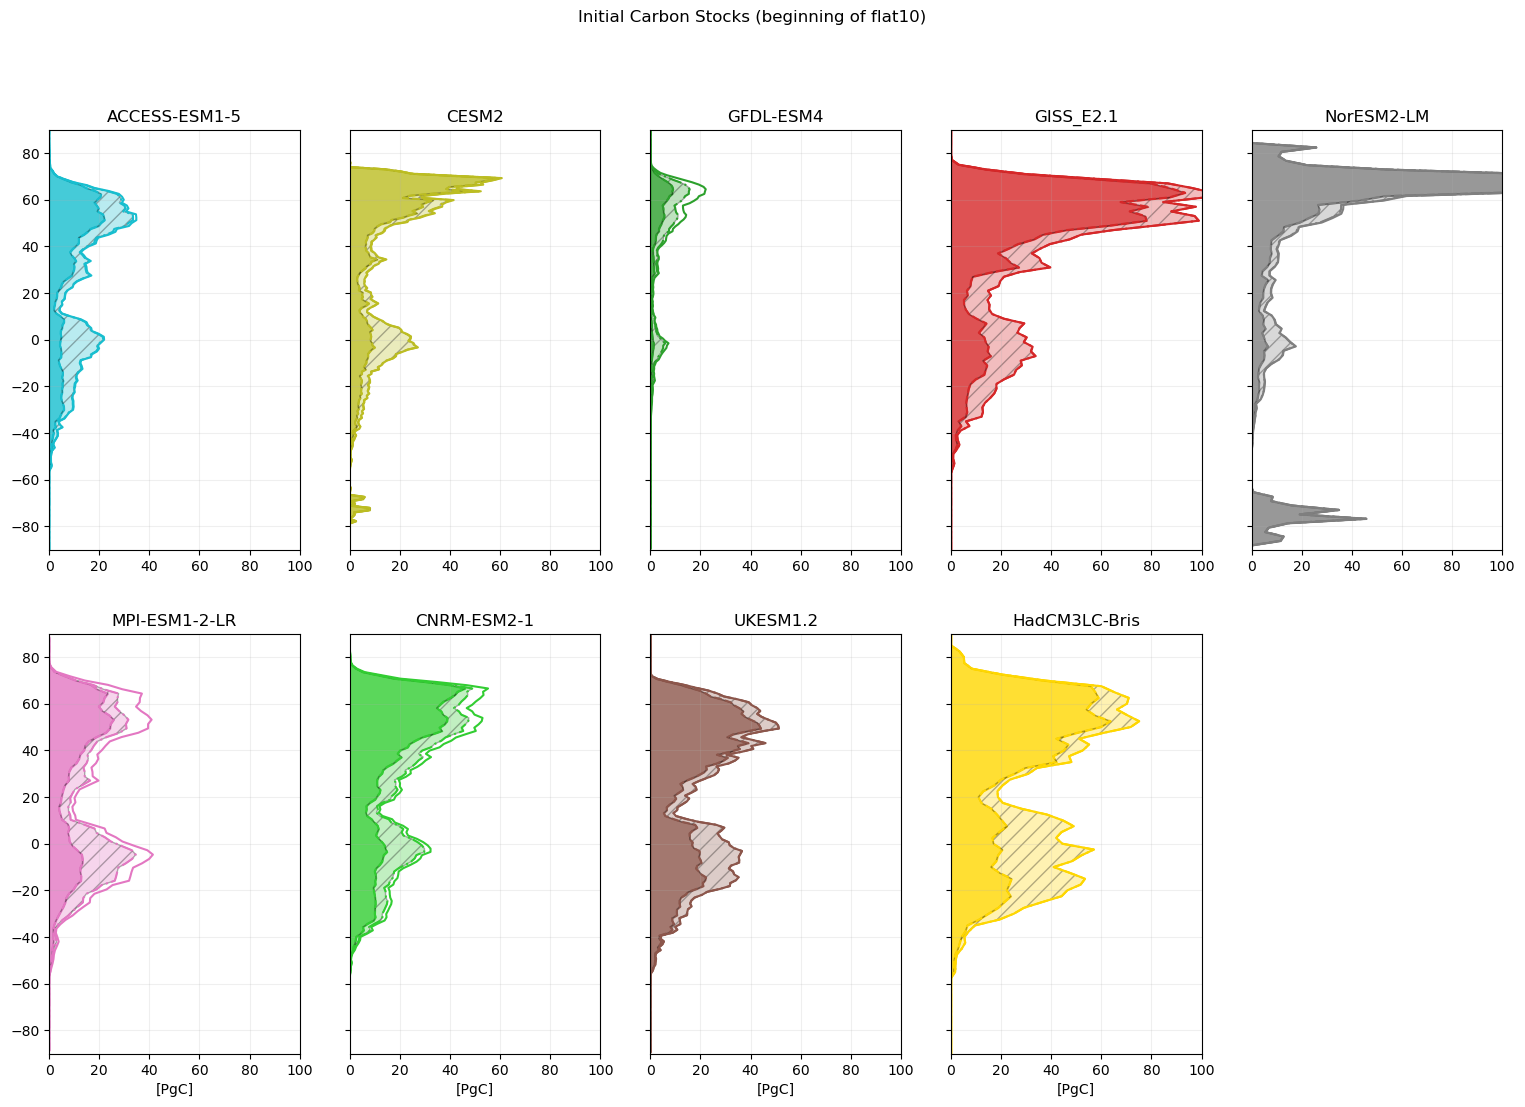

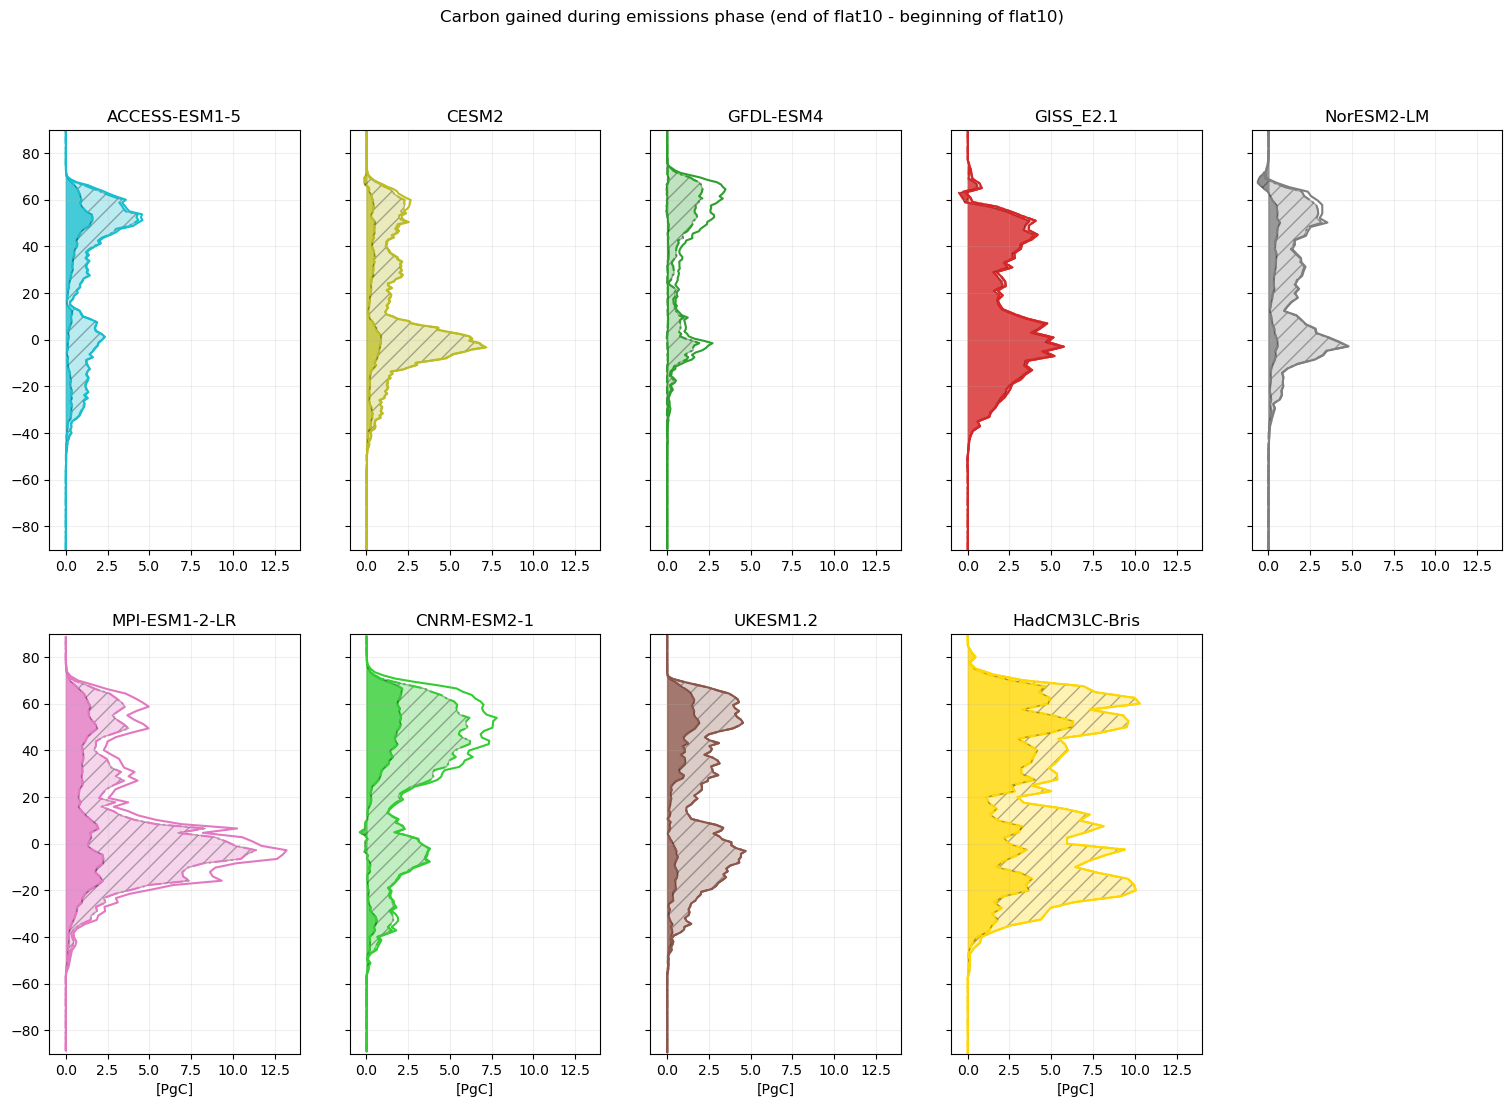

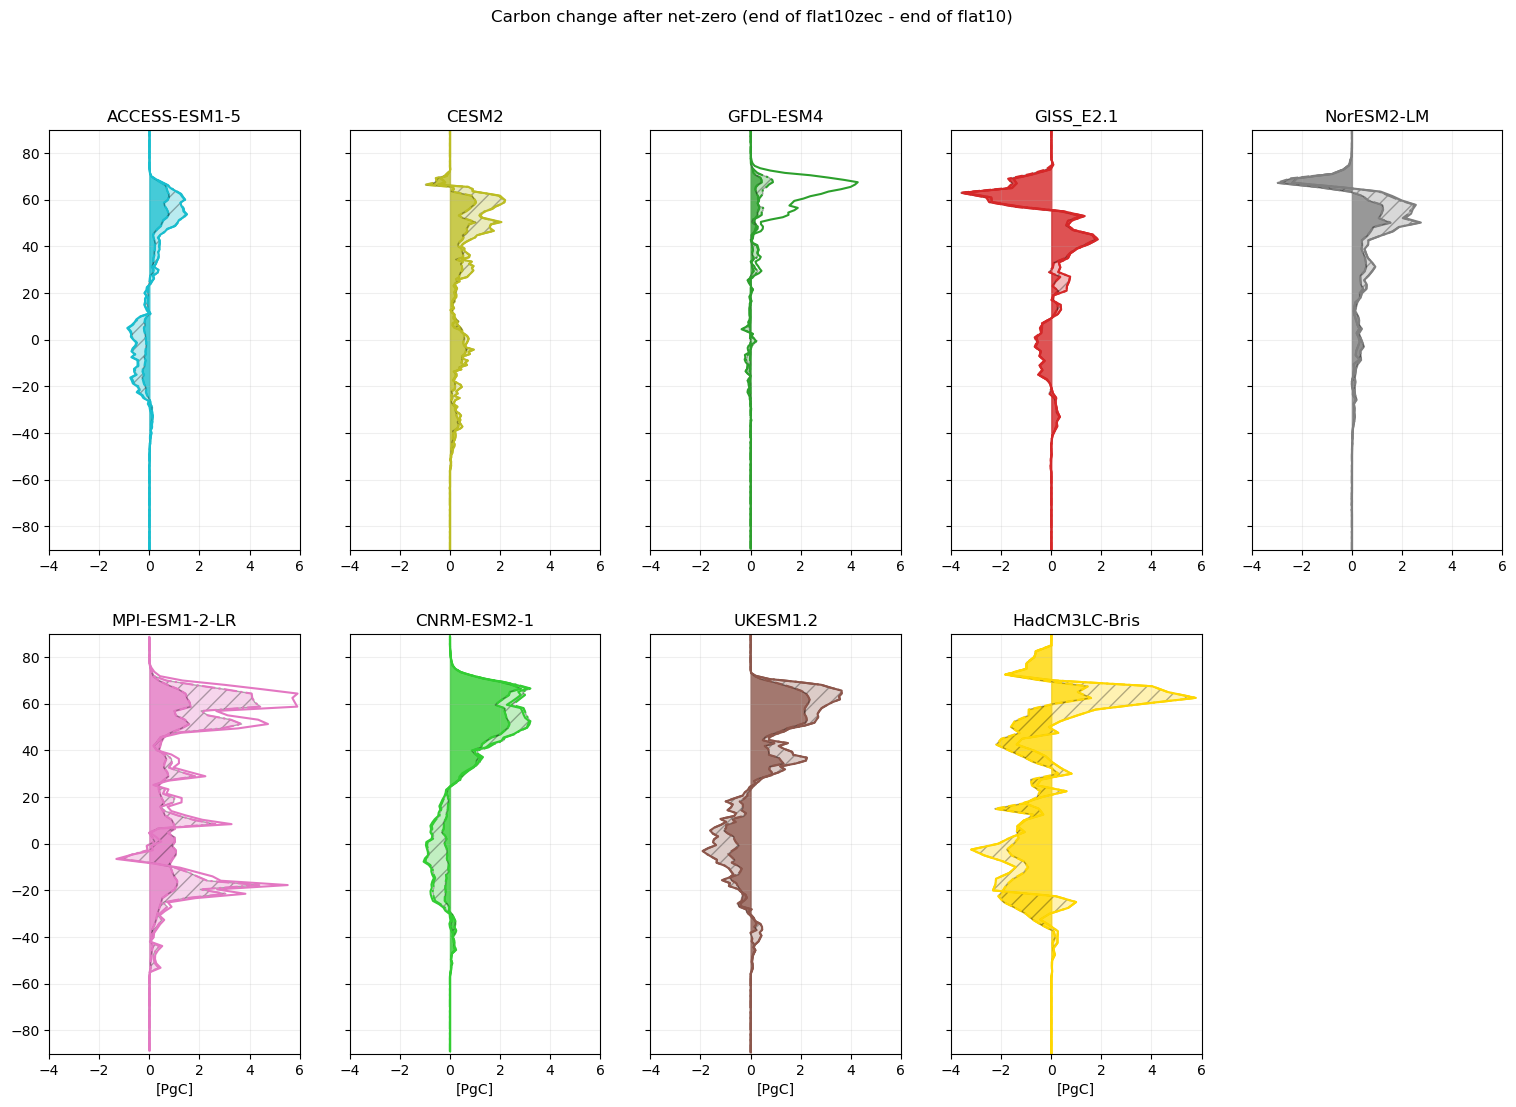

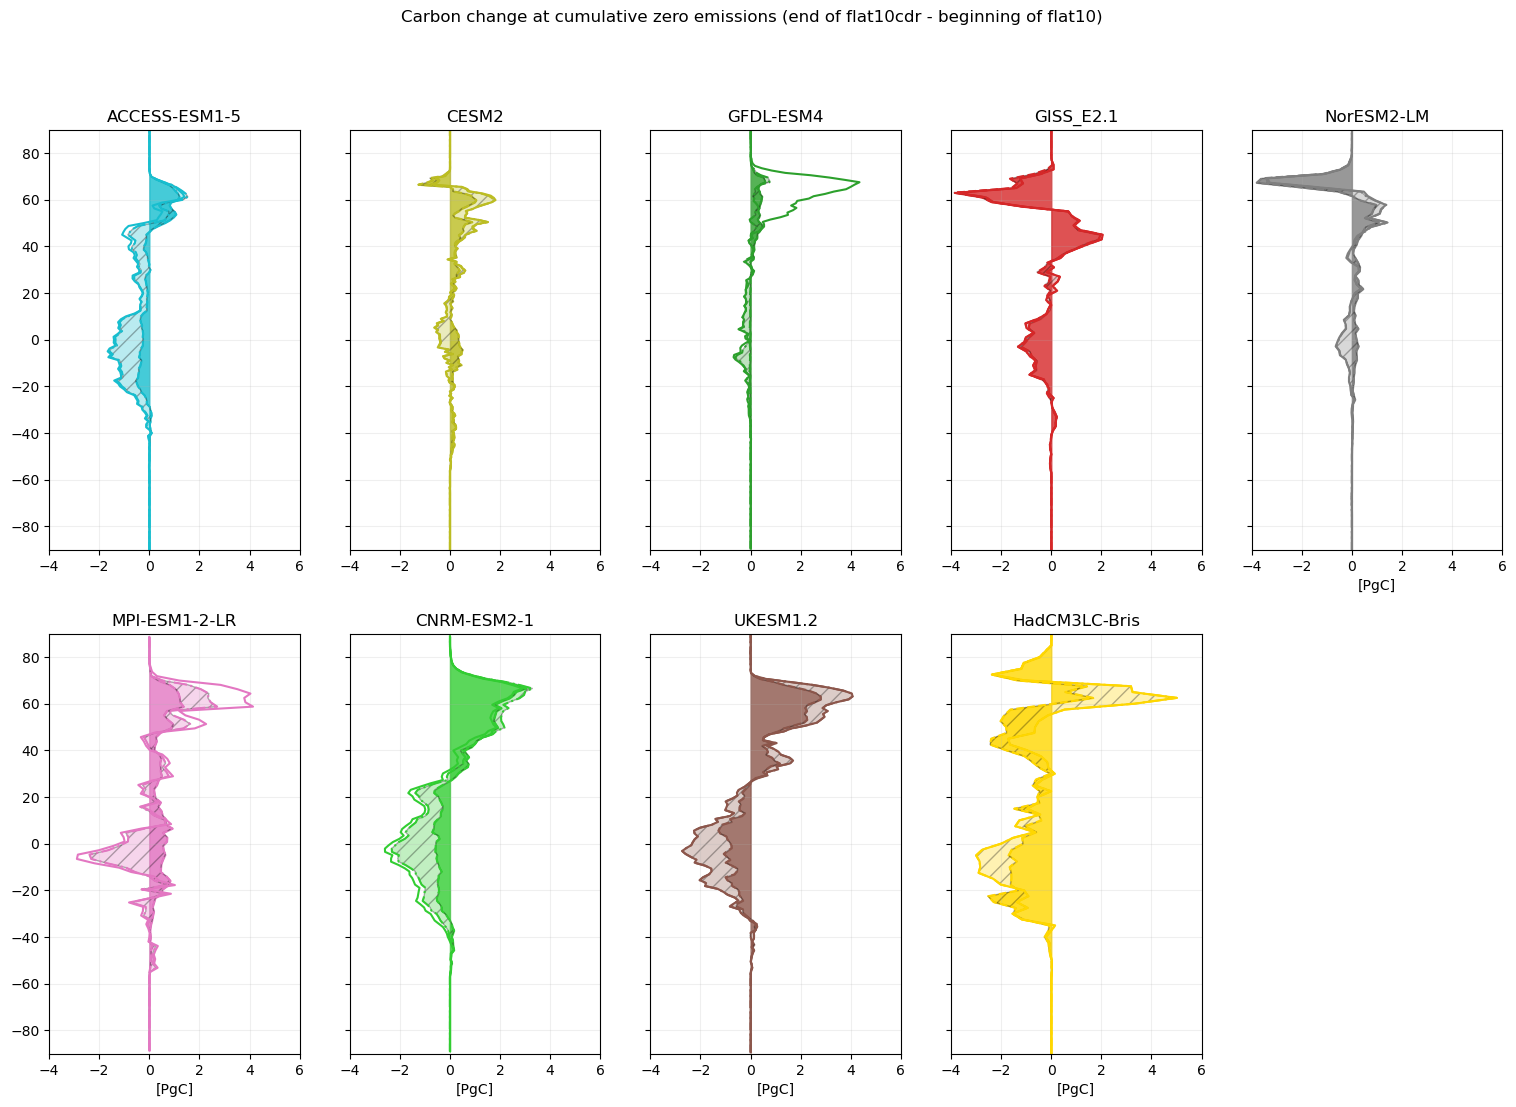

done saving file


In [43]:
# first column original units (kgC/m2)
# total carbon units (sum of all carbon, not per m2)

phasename=['InitialC','EmissionsPhase','NetZero','CumulativeZero']

num_rows=2
num_cols=5
fig0, axes0 = plt.subplots(num_rows,num_cols,figsize=(3.75 * num_cols, num_rows * 6 )) # initial C
fig1, axes1 = plt.subplots(num_rows,num_cols,figsize=(3.75 * num_cols, num_rows * 6 )) # emissions phase
fig2, axes2 = plt.subplots(num_rows,num_cols,figsize=(3.75 * num_cols, num_rows * 6 )) # net zero
fig3, axes3 = plt.subplots(num_rows,num_cols,figsize=(3.75 * num_cols, num_rows * 6 )) # cumulative zero

axes0=axes0.flatten()
axes1=axes1.flatten()
axes2=axes2.flatten()
axes3=axes3.flatten()


unitconvert=PgperKg
# zonal mean shaded plot, one plot for each model

# loop over models
for m in range(len(modellist)):
    model=modellist[m]
    print('Plotting ' +model)

    mcolor=modelcolors[m]

    # these will be loaded right here
    ds0g=load_one_model_onevar(model,runlist_wc[0],'cVeg')

    ###---- grid info
    lat = ds0g.lat

    #--- get area and land fraction
    ds_area = data_dict[modellist[m] +'_' +'areacella']
    ds_landfrac = data_dict[modellist[m] +'_' +'landfrac']
    
    if model=='CESM2':
        area = ds_area['areacella'].squeeze().reindex_like(ds0g, method='nearest',tolerance=0.05)
    else:
        area = ds_area['areacella'].reindex_like(ds0g, method='nearest',tolerance=0.05)
    
    landfrac=ds_landfrac['sftlf'].reindex_like(ds0g, method='nearest',tolerance=0.05)
    
    if landfrac.max(dim=['lat','lon'])>1: #test if landfrac is on a 0-100 or 0-1 scale
        landfrac=landfrac/100

    landarea=(area*landfrac)
    area_per_lat_m2=(area*landfrac).sum(dim='lon')

    #----###-----####----- cVeg
    var='cVeg'
    ds=load_one_model_onevar(model,runlist_wc[0],var) #load one model one experiment one var
    ds0=ds.mean(dim='lon') # zonal mean
    dsw=weighted_temporal_mean(ds0,var) # annual mean    
    del ds # drop full grid from memory   
    dst= select_time_slice(dsw, 0, 9) # first ten years of flat10
    dsften_cVeg = dst.mean(dim='time') # original units
    dsften_cVeg_PgC = unitconvert*(dst*landarea).sum(dim='lon').mean(dim='time') # converted to PgC
    dst=select_time_slice(dsw, 90, 99) # last ten years of flat10
    dslten0_cVeg = dst.mean(dim='time') # original units
    dslten0_cVeg_PgC = unitconvert*(dst*landarea).sum(dim='lon').mean(dim='time')# converted to PgC

    ds=load_one_model_onevar(model,runlist_wc[1],var) #load one model one experiment one var
    ds1=ds.mean(dim='lon') # zonal mean
    dsw=weighted_temporal_mean(ds1,var)
    del ds # drop full grid from memory
    dst = select_time_slice(dsw, 190, 199) #last ten years of flat10-zec
    dslten1_cVeg = dst.mean(dim='time') # original units
    dslten1_cVeg_PgC = unitconvert*(dst*landarea).sum(dim='lon').mean(dim='time')# converted to PgC

    ds=load_one_model_onevar(model,runlist_wc[2],var) #load one model one experiment one var
    ds2=ds.mean(dim='lon') # zonal mean
    dsw=weighted_temporal_mean(ds2,var)
    del ds # drop full grid from memory
    dst = select_time_slice(dsw, 190, 199) # last ten years of flat10-cdr
    dslten2_cVeg = dst.mean(dim='time') # original units
    dslten2_cVeg_PgC = unitconvert*(dst*landarea).sum(dim='lon').mean(dim='time')# converted to PgC


    #----###-----####----- cSoil
    var='cSoil'
    ds=load_one_model_onevar(model,runlist_wc[0],var) #load one model one experiment one var
    ds0=ds.mean(dim='lon') # zonal mean
    dsw=weighted_temporal_mean(ds0,var) # annual mean    
    del ds # drop full grid from memory   
    dst= select_time_slice(dsw, 0, 9) # first ten years of flat10
    dsften_cSoil = dst.mean(dim='time') # original units
    dsften_cSoil_PgC = unitconvert*(dst*landarea).sum(dim='lon').mean(dim='time') # converted to PgC
    dst=select_time_slice(dsw, 90, 99) # last ten years of flat10
    dslten0_cSoil = dst.mean(dim='time') # original units
    dslten0_cSoil_PgC = unitconvert*(dst*landarea).sum(dim='lon').mean(dim='time')# converted to PgC

    ds=load_one_model_onevar(model,runlist_wc[1],var) #load one model one experiment one var
    ds1=ds.mean(dim='lon') # zonal mean
    dsw=weighted_temporal_mean(ds1,var)
    del ds # drop full grid from memory
    dst = select_time_slice(dsw, 190, 199) #last ten years of flat10-zec
    dslten1_cSoil = dst.mean(dim='time') # original units
    dslten1_cSoil_PgC = unitconvert*(dst*landarea).sum(dim='lon').mean(dim='time')# converted to PgC

    ds=load_one_model_onevar(model,runlist_wc[2],var) #load one model one experiment one var
    ds2=ds.mean(dim='lon') # zonal mean
    dsw=weighted_temporal_mean(ds2,var)
    del ds # drop full grid from memory
    dst = select_time_slice(dsw, 190, 199) # last ten years of flat10-cdr
    dslten2_cSoil = dst.mean(dim='time') # original units
    dslten2_cSoil_PgC = unitconvert*(dst*landarea).sum(dim='lon').mean(dim='time')# converted to PgC


    #----###-----####----- cLitter
    var='cLitter'
    ds=load_one_model_onevar(model,runlist_wc[0],var) #load one model one experiment one var
    if ds is not None:
        ds0=ds.mean(dim='lon') # zonal mean
        dsw=weighted_temporal_mean(ds0,var) # annual mean    
        del ds # drop full grid from memory   
        dst= select_time_slice(dsw, 0, 9) # first ten years of flat10
        dsften_cLitter = dst.mean(dim='time') # original units
        dsften_cLitter_PgC = unitconvert*(dst*landarea).sum(dim='lon').mean(dim='time') # converted to PgC
        dst=select_time_slice(dsw, 90, 99) # last ten years of flat10
        dslten0_cLitter = dst.mean(dim='time') # original units
        dslten0_cLitter_PgC = unitconvert*(dst*landarea).sum(dim='lon').mean(dim='time')# converted to PgC
    
        ds=load_one_model_onevar(model,runlist_wc[1],var) #load one model one experiment one var
        ds1=ds.mean(dim='lon') # zonal mean
        dsw=weighted_temporal_mean(ds1,var)
        del ds # drop full grid from memory
        dst = select_time_slice(dsw, 190, 199) #last ten years of flat10-zec
        dslten1_cLitter = dst.mean(dim='time') # original units
        dslten1_cLitter_PgC = unitconvert*(dst*landarea).sum(dim='lon').mean(dim='time')# converted to PgC
    
        ds=load_one_model_onevar(model,runlist_wc[2],var) #load one model one experiment one var
        ds2=ds.mean(dim='lon') # zonal mean
        dsw=weighted_temporal_mean(ds2,var)
        del ds # drop full grid from memory
        dst = select_time_slice(dsw, 190, 199) # last ten years of flat10-cdr
        dslten2_cLitter = dst .mean(dim='time') # original units
        dslten2_cLitter_PgC = unitconvert*(dst*landarea).sum(dim='lon').mean(dim='time')# converted to PgC
    
    
        #----###-----####----- cTot
        # derived variable, sum of Veg, Soil, Litter
        # var='cTot'
        dsften_cTot = dsften_cVeg + dsften_cSoil + dsften_cLitter
        dsften_cTot_PgC = dsften_cVeg_PgC + dsften_cSoil_PgC + dsften_cLitter_PgC
        dslten0_cTot = dslten0_cVeg + dslten0_cSoil + dslten0_cLitter
        dslten0_cTot_PgC = dslten0_cVeg_PgC + dslten0_cSoil_PgC + dslten0_cLitter_PgC
        dslten1_cTot = dslten1_cVeg + dslten1_cSoil + dslten1_cLitter
        dslten1_cTot_PgC = dslten1_cVeg_PgC + dslten1_cSoil_PgC + dslten1_cLitter_PgC
        dslten2_cTot = dslten2_cVeg + dslten2_cSoil + dslten2_cLitter
        dslten2_cTot_PgC = dslten2_cVeg_PgC + dslten2_cSoil_PgC + dslten2_cLitter_PgC

    else: # litter variable doesn't exist
        #----###-----####----- cTot
        # derived variable, sum of Veg, Soil, but NOT litter
        # var='cTot'
        dsften_cTot = dsften_cVeg + dsften_cSoil
        dsften_cTot_PgC = dsften_cVeg_PgC + dsften_cSoil_PgC
        dslten0_cTot = dslten0_cVeg + dslten0_cSoil 
        dslten0_cTot_PgC = dslten0_cVeg_PgC + dslten0_cSoil_PgC 
        dslten1_cTot = dslten1_cVeg + dslten1_cSoil 
        dslten1_cTot_PgC = dslten1_cVeg_PgC + dslten1_cSoil_PgC 
        dslten2_cTot = dslten2_cVeg + dslten2_cSoil 
        dslten2_cTot_PgC = dslten2_cVeg_PgC + dslten2_cSoil_PgC 

    #  drop some things from memory
    del ds0, ds1, ds2
    
    ###----------------------Plot-------------------------###

    # to use, refer to one index in axs: ax = axs[row, column]


    #--------------------------Second row is total carbon units (PgC)
    #---First column is flat10 climatology
    #--- first column is the climatology, or average of first 10 years 
    ax = axes0[m]


    # plot lines soil, veg + soil, total-litter, total
#    dsften_cTot.plot(ax=ax,y='lat', linestyle='-',color=mcolor,label='Total')
#    dsften_cSoil.plot(ax=ax,y='lat', linestyle='--',color=mcolor,label='_nolabel_')
#    (dsften_cVeg+dsften_cSoil).plot(ax=ax,y='lat', linestyle='-.',color=mcolor,label='_nolabel_')
    #(dsften_cTot-dsften_cLitter).mean(dim='time').plot(ax=ax,y='lat',label=model, linestyle='.-',color=mcolor)

    ax.plot(dsften_cTot_PgC,lat, linestyle='-',color=mcolor,label='Total')
    ax.plot(dsften_cSoil_PgC,lat, linestyle='--',color=mcolor,label='_nolabel_')
    ax.plot((dsften_cVeg_PgC+dsften_cSoil_PgC),lat, linestyle='-.',color=mcolor,label='_nolabel_')

    # plot shaded area
    # soil, soil to veg
    #ax.fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
    fg = ax.fill_betweenx(lat,0, dsften_cSoil_PgC,alpha=0.8,color=mcolor,label='Soil')
    fg2 = ax.fill_betweenx(lat,dsften_cSoil_PgC,dsften_cSoil_PgC+dsften_cVeg_PgC,alpha=0.3,color=mcolor,label='Veg',hatch='//',edgecolor='black')

    ax.set_ylim([-90, 90])
    ax.grid(True,alpha=0.2, zorder=0)
    ax.set_ylabel('')
    ax.set_title(model)
    if (m!=0 and m!=num_cols): #remove y ticks for plots that are not on the left hand edge of the plot
        ax.set_yticklabels([])
    
    ax.set_xlim([0, 100])

    if m>num_cols-1:
        ax.set_xlabel('[PgC]')
    
    #--- Second column is end of flat10 emissions phase
    ax = axes1[m]
    #dsdelta=(dslten0.mean(dim='time')-dsften.mean(dim='time')).mean(dim='lon') #last 10 years of flat10 minus first ten years of flat10-zec
    #.plot(ax=ax,y='lat',label=model, linestyle='-',color=mcolor)
    

    # plot lines soil, veg + soil, total-litter, total
    (dslten0_cTot_PgC-dsften_cTot_PgC).plot(ax=ax,y='lat', linestyle='-',color=mcolor,label='Total')
    (dslten0_cSoil_PgC-dsften_cSoil_PgC).plot(ax=ax,y='lat', linestyle='--',color=mcolor,label='_nolabel_')
    ((dslten0_cVeg_PgC+dslten0_cSoil_PgC)-(dsften_cVeg_PgC+dsften_cSoil_PgC)).plot(ax=ax,y='lat', linestyle='-.',color=mcolor,label='_nolabel_')
    #(dsften_cTot-dsften_cLitter).mean(dim='time').plot(ax=ax,y='lat',label=model, linestyle='.-',color=mcolor)

    # plot shaded area
    # soil, soil to veg
    #ax.fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
    fg = ax.fill_betweenx(lat,0, dslten0_cSoil_PgC-dsften_cSoil_PgC,alpha=0.8,color=mcolor,label='Soil')
    fg2 = ax.fill_betweenx(lat,dslten0_cSoil_PgC-dsften_cSoil_PgC,(dslten0_cSoil_PgC-dsften_cSoil_PgC)+(dslten0_cVeg_PgC-dsften_cVeg_PgC),alpha=0.3,color=mcolor,label='Veg',hatch='//',edgecolor='black')

    ax.set_ylim([-90, 90])
    ax.grid(True,alpha=0.2, zorder=0)
    ax.set_ylabel('')
    ax.set_title(model)
    if (m!=0 and m!=num_cols): #remove y ticks for plots that are not on the left hand edge of the plot
        ax.set_yticklabels([])

    ax.set_xlim([-1, 14])

    if m>num_cols-1:
        ax.set_xlabel('[PgC]')

    #--- Third column is end of flat10zec phase
    ax = axes2[m] 
    #dsdelta=dslten1.mean(dim='time')-dslten0.mean(dim='time') #last 10 years of flat10-zec minus last 10 years of flat10
    #fg = dsdelta.mean(dim='lon').plot(ax=ax,y='lat',label=model, linestyle='-',color=mcolor) 

    # plot lines soil, veg + soil, total-litter, total
    (dslten1_cTot_PgC-dslten0_cTot_PgC).plot(ax=ax,y='lat', linestyle='-',color=mcolor,label='Total')
    (dslten1_cSoil_PgC-dslten0_cSoil_PgC).plot(ax=ax,y='lat', linestyle='--',color=mcolor,label='_nolabel_')
    ((dslten1_cVeg_PgC+dslten1_cSoil_PgC)-(dslten0_cVeg_PgC+dslten0_cSoil_PgC)).plot(ax=ax,y='lat', linestyle='-.',color=mcolor,label='_nolabel_')
    #(dsften_cTot-dsften_cLitter).mean(dim='time').plot(ax=ax,y='lat',label=model, linestyle='.-',color=mcolor)

    # plot shaded area
    # soil, soil to veg
    #ax.fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
    fg = ax.fill_betweenx(lat,0, dslten1_cSoil_PgC-dslten0_cSoil_PgC,alpha=0.8,color=mcolor,label='Soil')
    fg2 = ax.fill_betweenx(lat,dslten1_cSoil_PgC-dslten0_cSoil_PgC,(dslten1_cSoil_PgC-dslten0_cSoil_PgC)+(dslten1_cVeg_PgC-dslten0_cVeg_PgC),alpha=0.3,color=mcolor,label='Veg',hatch='//',edgecolor='black')

    ax.set_ylim([-90, 90])
    ax.grid(True,alpha=0.2, zorder=0)
    ax.set_ylabel('')
    ax.set_title(model)
    if (m!=0 and m!=num_cols): #remove y ticks for plots that are not on the left hand edge of the plot
        ax.set_yticklabels([])

    ax.set_xlim([-4, 6])

    if m>num_cols-1:
        ax.set_xlabel('[PgC]')
        
    #--- Fourth column is end of flat10cdr phase

    ax = axes3[m] 

    #dsdelta=dslten2.mean(dim='time')-dsften.mean(dim='time') #last 10 years of flat10-cdr minus first ten years of flat10
    #fg = dsdelta.mean(dim='lon').plot(ax=ax,y='lat',label=model, linestyle='-',color=mcolor) 


    # plot lines soil, veg + soil, total-litter, total
    (dslten2_cTot_PgC-dsften_cTot_PgC).plot(ax=ax,y='lat', linestyle='-',color=mcolor,label='Total')
    (dslten2_cSoil_PgC-dsften_cSoil_PgC).plot(ax=ax,y='lat', linestyle='--',color=mcolor,label='_nolabel_')
    ((dslten2_cVeg_PgC+dslten2_cSoil_PgC)-(dsften_cVeg_PgC+dsften_cSoil_PgC)).plot(ax=ax,y='lat', linestyle='-.',color=mcolor,label='_nolabel_')
    #(dsften_cTot-dsften_cLitter).mean(dim='time').plot(ax=ax,y='lat',label=model, linestyle='.-',color=mcolor)
    
    # plot shaded area
    # soil, soil to veg
    #ax.fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
    fg = ax.fill_betweenx(lat,0, dslten2_cSoil_PgC-dsften_cSoil_PgC,alpha=0.8,color=mcolor,label='Soil')
    fg2 = ax.fill_betweenx(lat,dslten2_cSoil_PgC-dsften_cSoil_PgC,(dslten2_cSoil_PgC-dsften_cSoil_PgC)+(dslten2_cVeg_PgC-dsften_cVeg_PgC),alpha=0.3,color=mcolor,label='Veg',hatch='//',edgecolor='black')

    ax.set_ylim([-90, 90])
    ax.grid(True,alpha=0.2, zorder=0)
    ax.set_ylabel('')
    ax.set_title(model)
    if (m!=0 and m!=num_cols): #remove y ticks for plots that are not on the left hand edge of the plot
        ax.set_yticklabels([])
    
    ax.set_xlim([-4, 6])

    if m>num_cols-2:
        ax.set_xlabel('[PgC]')
    

# add gridlines
#axes0[m].grid(True,alpha=0.2, zorder=0)

# remve the empty plot in the last slot - if we add a model will need to disable this!
axes0[9].set_visible(False) 
axes1[9].set_visible(False)
axes2[9].set_visible(False) 
axes3[9].set_visible(False)

# set title over whole plot
fig0.suptitle('Initial Carbon Stocks (beginning of flat10)')
fig1.suptitle('Carbon gained during emissions phase (end of flat10 - beginning of flat10)')
fig2.suptitle('Carbon change after net-zero (end of flat10zec - end of flat10)')
fig3.suptitle('Carbon change at cumulative zero emissions (end of flat10cdr - beginning of flat10)')

# show the plot:
plt.show()

# save the plot
fig0.savefig('figures/' +'Cdelta_zonal_lineplot_allmodels_' +phasename[0] +'.png', bbox_inches='tight', dpi=400)
plt.close(fig0)

fig1.savefig('figures/' +'Cdelta_zonal_lineplot_allmodels_' +phasename[1] +'.png', bbox_inches='tight', dpi=400)
plt.close(fig1)

fig2.savefig('figures/' +'Cdelta_zonal_lineplot_allmodels_' +phasename[2] +'.png', bbox_inches='tight', dpi=400)
plt.close(fig2)

fig3.savefig('figures/' +'Cdelta_zonal_lineplot_allmodels_' +phasename[3] +'.png', bbox_inches='tight', dpi=400)
plt.close(fig3)

print('done saving file')

# close the plot (so python stops trying to hold on to it in memory; you can
# still look at it at this point, but you're done editing)
# plt.close()


In [ ]:
fig0, axes0 = plt.subplots(num_rows,num_cols,figsize=(3.75 * num_cols, num_rows * 6 ))
axes0=axes0.flatten()
axes0[9].set_visible(False)

In [ ]:
#dslten0_cTot
dsften_cTot

In [ ]:
# per area units

unitconvert=1
# zonal mean shaded plot, one plot for each model

# loop over models
for m in range(len(modellist)):
    model=modellist[m]
    print('Plotting ' +model)

    mcolor=modelcolors[m]

    # Create a figure and axis objects
    num_rows=1
    fig, axs = plt.subplots(num_rows, 4, figsize=(15, num_rows * 5))

    
    # create datasets for each model + experiment combination + variable
    # these are already subset to the correct time blocks
    
    ds0 = data_dict[modellist[m] +'_' +runlist[0]] #flat10
    ds1 = data_dict[modellist[m] +'_' +runlist[1]] #flat10-zec
    ds2 = data_dict[modellist[m] +'_' +runlist[2]] #flat10-cdr
    
    lat = ds0.lat
    
    #----###-----####----- cTot
    var='cTot'
    dsw=weighted_temporal_mean(ds0,var)*unitconvert
    dst= select_time_slice(dsw, 0, 9) # first ten years of flat10
    dsften_cTot = dst.mean(dim='lon').mean(dim='time')
    dst=select_time_slice(dsw, 90, 99) # last ten years of flat10
    dslten0_cTot = dst.mean(dim='lon').mean(dim='time')
    
    dsw=weighted_temporal_mean(ds1,var)*unitconvert
    dst = select_time_slice(dsw, 190, 199) #last ten years of flat10-zec
    dslten1_cTot = dst.mean(dim='lon').mean(dim='time')
    
    dsw=weighted_temporal_mean(ds2,var)*unitconvert
    dst = select_time_slice(dsw, 190, 199) # last ten years of flat10-cdr
    dslten2_cTot = dst.mean(dim='lon').mean(dim='time')
    
    
    #----###-----####----- cVeg
    var='cVeg'
    dsw=weighted_temporal_mean(ds0,var)*unitconvert
    dst= select_time_slice(dsw, 0, 9) # first ten years of flat10
    dsften_cVeg = dst.mean(dim='lon').mean(dim='time')
    dst=select_time_slice(dsw, 90, 99) # last ten years of flat10
    dslten0_cVeg = dst.mean(dim='lon').mean(dim='time')
    
    dsw=weighted_temporal_mean(ds1,var)*unitconvert
    dst = select_time_slice(dsw, 190, 199) #last ten years of flat10-zec
    dslten1_cVeg = dst.mean(dim='lon').mean(dim='time')
    
    dsw=weighted_temporal_mean(ds2,var)*unitconvert
    dst = select_time_slice(dsw, 190, 199) # last ten years of flat10-cdr
    dslten2_cVeg = dst.mean(dim='lon').mean(dim='time')
    
    
    #----###-----####----- cSoil
    var='cSoil'
    dsw=weighted_temporal_mean(ds0,var)*unitconvert
    dst= select_time_slice(dsw, 0, 9) # first ten years of flat10
    dsften_cSoil = dst.mean(dim='lon').mean(dim='time')
    dst=select_time_slice(dsw, 90, 99) # last ten years of flat10
    dslten0_cSoil = dst.mean(dim='lon').mean(dim='time')
    
    dsw=weighted_temporal_mean(ds1,var)*unitconvert
    dst = select_time_slice(dsw, 190, 199) #last ten years of flat10-zec
    dslten1_cSoil = dst.mean(dim='lon').mean(dim='time')
    
    dsw=weighted_temporal_mean(ds2,var)*unitconvert
    dst = select_time_slice(dsw, 190, 199) # last ten years of flat10-cdr
    dslten2_cSoil = dst.mean(dim='lon').mean(dim='time')
    
    
    #----###-----####----- cLitter
    var='cLitter'
    dsw=weighted_temporal_mean(ds0,var)*unitconvert
    dst= select_time_slice(dsw, 0, 9) # first ten years of flat10
    dsften_cLitter = dst.mean(dim='lon').mean(dim='time')
    dst=select_time_slice(dsw, 90, 99) # last ten years of flat10
    dslten0_cLitter = dst.mean(dim='lon').mean(dim='time')
    
    dsw=weighted_temporal_mean(ds1,var)*unitconvert
    dst = select_time_slice(dsw, 190, 199) #last ten years of flat10-zec
    dslten1_cLitter = dst.mean(dim='lon').mean(dim='time')
    
    dsw=weighted_temporal_mean(ds2,var)*unitconvert
    dst = select_time_slice(dsw, 190, 199) # last ten years of flat10-cdr
    dslten2_cLitter = dst.mean(dim='lon').mean(dim='time')
    ###----
    
    ###----------------------Plot-------------------------###
    
    


    # to use, refer to one index in axs: ax = axs[row, column]

    #---First column is flat10 climatology
    #--- first column is the climatology, or average of first 10 years 
    ax = axs[0] 

    # plot lines soil, veg + soil, total-litter, total
    dsften_cTot.plot(ax=ax,y='lat', linestyle='-',color=mcolor,label='Total')
    dsften_cSoil.plot(ax=ax,y='lat', linestyle='--',color=mcolor,label='_nolabel_')
    (dsften_cVeg+dsften_cSoil).plot(ax=ax,y='lat', linestyle='-.',color=mcolor,label='_nolabel_')
    #(dsften_cTot-dsften_cLitter).mean(dim='time').plot(ax=ax,y='lat',label=model, linestyle='.-',color=mcolor)

    # plot shaded area
    # soil, soil to veg
    #ax.fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
    fg = ax.fill_betweenx(lat,0, dsften_cSoil,alpha=0.8,color=mcolor,label='Soil')
    fg2 = ax.fill_betweenx(lat,dsften_cSoil,dsften_cSoil+dsften_cVeg,alpha=0.3,color=mcolor,label='Veg',hatch='//',edgecolor='black')


    #--- Second column is end of flat10 emissions phase
    ax = axs[1]  
    #dsdelta=(dslten0.mean(dim='time')-dsften.mean(dim='time')).mean(dim='lon') #last 10 years of flat10 minus first ten years of flat10-zec
    #.plot(ax=ax,y='lat',label=model, linestyle='-',color=mcolor)


    # plot lines soil, veg + soil, total-litter, total
    (dslten0_cTot-dsften_cTot).plot(ax=ax,y='lat', linestyle='-',color=mcolor,label='Total')
    (dslten0_cSoil-dsften_cSoil).plot(ax=ax,y='lat', linestyle='--',color=mcolor,label='_nolabel_')
    ((dslten0_cVeg+dslten0_cSoil)-(dsften_cVeg+dsften_cSoil)).plot(ax=ax,y='lat', linestyle='-.',color=mcolor,label='_nolabel_')
    #(dsften_cTot-dsften_cLitter).mean(dim='time').plot(ax=ax,y='lat',label=model, linestyle='.-',color=mcolor)

    # plot shaded area
    # soil, soil to veg
    #ax.fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
    fg = ax.fill_betweenx(lat,0, dslten0_cSoil-dsften_cSoil,alpha=0.8,color=mcolor,label='Soil')
    fg2 = ax.fill_betweenx(lat,dslten0_cSoil-dsften_cSoil,(dslten0_cSoil-dsften_cSoil)+(dslten0_cVeg-dsften_cVeg),alpha=0.3,color=mcolor,label='Veg',hatch='//',edgecolor='black')

    #--- Third column is end of flat10zec phase
    ax = axs[2] 
    #dsdelta=dslten1.mean(dim='time')-dslten0.mean(dim='time') #last 10 years of flat10-zec minus last 10 years of flat10
    #fg = dsdelta.mean(dim='lon').plot(ax=ax,y='lat',label=model, linestyle='-',color=mcolor) 

    # plot lines soil, veg + soil, total-litter, total
    (dslten1_cTot-dslten0_cTot).plot(ax=ax,y='lat', linestyle='-',color=mcolor,label='Total')
    (dslten1_cSoil-dslten0_cSoil).plot(ax=ax,y='lat', linestyle='--',color=mcolor,label='_nolabel_')
    ((dslten1_cVeg+dslten1_cSoil)-(dslten0_cVeg+dslten0_cSoil)).plot(ax=ax,y='lat', linestyle='-.',color=mcolor,label='_nolabel_')
    #(dsften_cTot-dsften_cLitter).mean(dim='time').plot(ax=ax,y='lat',label=model, linestyle='.-',color=mcolor)

    # plot shaded area
    # soil, soil to veg
    #ax.fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
    fg = ax.fill_betweenx(lat,0, dslten1_cSoil-dslten0_cSoil,alpha=0.8,color=mcolor,label='Soil')
    fg2 = ax.fill_betweenx(lat,dslten1_cSoil-dslten0_cSoil,(dslten1_cSoil-dslten0_cSoil)+(dslten1_cVeg-dslten0_cVeg),alpha=0.3,color=mcolor,label='Veg',hatch='//',edgecolor='black')

    #--- Fourth column is end of flat10cdr phase

    ax = axs[3] 

    #dsdelta=dslten2.mean(dim='time')-dsften.mean(dim='time') #last 10 years of flat10-cdr minus first ten years of flat10
    #fg = dsdelta.mean(dim='lon').plot(ax=ax,y='lat',label=model, linestyle='-',color=mcolor) 


    # plot lines soil, veg + soil, total-litter, total
    (dslten2_cTot-dsften_cTot).plot(ax=ax,y='lat', linestyle='-',color=mcolor,label='Total')
    (dslten2_cSoil-dsften_cSoil).plot(ax=ax,y='lat', linestyle='--',color=mcolor,label='_nolabel_')
    ((dslten2_cVeg+dslten2_cSoil)-(dsften_cVeg+dsften_cSoil)).plot(ax=ax,y='lat', linestyle='-.',color=mcolor,label='_nolabel_')
    #(dsften_cTot-dsften_cLitter).mean(dim='time').plot(ax=ax,y='lat',label=model, linestyle='.-',color=mcolor)

    # plot shaded area
    # soil, soil to veg
    #ax.fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
    fg = ax.fill_betweenx(lat,0, dslten2_cSoil-dsften_cSoil,alpha=0.8,color=mcolor,label='Soil')
    fg2 = ax.fill_betweenx(lat,dslten2_cSoil-dsften_cSoil,(dslten2_cSoil-dsften_cSoil)+(dslten2_cVeg-dsften_cVeg),alpha=0.3,color=mcolor,label='Veg',hatch='//',edgecolor='black')


    #-- try setting some properties after the loop through models
    ax=axs[0]
    ax.set_ylim([-90, 90])
    ax.grid(True)
    ax.set_ylabel(model)
    ax.set_xlabel('kgC/m2')
    ax.legend()
    
    ax=axs[1]
    ax.set_ylim([-90, 90])
    ax.grid(True)
    ax.set_xlabel('kgC/m2')
    ax.set_ylabel('')
    
    ax=axs[2]
    ax.set_ylim([-90, 90])
    ax.grid(True)
    ax.set_xlabel('kgC/m2')
    ax.set_ylabel('')
    
    ax=axs[3]
    ax.set_ylim([-90, 90])
    ax.grid(True)
    ax.set_xlabel('kgC/m2')
    ax.set_ylabel('')
    

    # set titles for top row of plots
    ax=axs[0]
    ax.set_title('initial state \n beginning of flat10')
    
    ax=axs[1]
    ax.set_title('carbon gained during emissions phase \n end of flat10 - beginning of flat10')
    
    ax=axs[2]
    ax.set_title('carbon change after net-zero \n end of flat10zec - end of flat10')
    
    ax=axs[3]
    ax.set_title('carbon reversibility \n end of flat10cdr - beginning of flat10')
    
    
    
    
    # show the plot:
    plt.show()
    
    # save the plot
    fig.savefig('figures/' +'Cdelta_zonal_lineplot_' +model +'.png', bbox_inches='tight', dpi=400)
    fig.savefig('figures/' +'Cdelta_zonal_lineplot_' +model +'.pdf', bbox_inches='tight')
    
    print('done saving file')
    
    # close the plot (so python stops trying to hold on to it in memory; you can
    # still look at it at this point, but you're done editing)
    plt.close()


In [ ]:
# total carbon units (sum of all carbon, not per m2)

unitconvert=PgperKg
# zonal mean shaded plot, one plot for each model

# loop over models
for m in range(len(modellist)):
    model=modellist[m]
    print('Plotting ' +model)

    mcolor=modelcolors[m]

    # Create a figure and axis objects
    num_rows=1
    fig, axs = plt.subplots(num_rows, 4, figsize=(15, num_rows * 5))

    
    # create datasets for each model + experiment combination + variable
    # these are already subset to the correct time blocks
    
    ds0 = data_dict[modellist[m] +'_' +runlist[0]] #flat10
    ds1 = data_dict[modellist[m] +'_' +runlist[1]] #flat10-zec
    ds2 = data_dict[modellist[m] +'_' +runlist[2]] #flat10-cdr
    
    lat = ds0.lat

    #--- get area and land fraction
    ds_area = data_dict[modellist[m] +'_' +'areacella']
    ds_landfrac = data_dict[modellist[m] +'_' +'landfrac']
    
    if model=='CESM2':
        area = ds_area['areacella'].squeeze().reindex_like(ds0, method='nearest',tolerance=0.05)
    #elif model=='GISS_E2.1':
    #    area_vec = ds_area['areacella'][:,-1]
    #    area,lf = xr.broadcast(area_vec,ds_landfrac['sftlf'])
    else:
        area = ds_area['areacella'].reindex_like(ds0, method='nearest',tolerance=0.05)
    
    landfrac=ds_landfrac['sftlf'].reindex_like(ds0, method='nearest',tolerance=0.05)
    
    if landfrac.max(dim=['lat','lon'])>1: #test if landfrac is on a 0-100 or 0-1 scale
        landfrac=landfrac/100
        
    landarea=(area*landfrac)
    area_per_lat_m2=(area*landfrac).sum(dim='lon')
    
    #----###-----####----- cTot
    var='cTot'
    dsw=weighted_temporal_mean(ds0,var)*unitconvert
    dst= select_time_slice(dsw, 0, 9) # first ten years of flat10
    dsften_cTot = (dst*landarea).sum(dim='lon').mean(dim='time')
    dst=select_time_slice(dsw, 90, 99) # last ten years of flat10
    dslten0_cTot = (dst*landarea).sum(dim='lon').mean(dim='time')
    
    dsw=weighted_temporal_mean(ds1,var)*unitconvert
    dst = select_time_slice(dsw, 190, 199) #last ten years of flat10-zec
    dslten1_cTot = (dst*landarea).sum(dim='lon').mean(dim='time')
    
    dsw=weighted_temporal_mean(ds2,var)*unitconvert
    dst = select_time_slice(dsw, 190, 199) # last ten years of flat10-cdr
    dslten2_cTot = (dst*landarea).sum(dim='lon').mean(dim='time')
    
    
    #----###-----####----- cVeg
    var='cVeg'
    dsw=weighted_temporal_mean(ds0,var)*unitconvert
    dst= select_time_slice(dsw, 0, 9) # first ten years of flat10
    dsften_cVeg = (dst*landarea).sum(dim='lon').mean(dim='time')
    dst=select_time_slice(dsw, 90, 99) # last ten years of flat10
    dslten0_cVeg = (dst*landarea).sum(dim='lon').mean(dim='time')
    
    dsw=weighted_temporal_mean(ds1,var)*unitconvert
    dst = select_time_slice(dsw, 190, 199) #last ten years of flat10-zec
    dslten1_cVeg = (dst*landarea).sum(dim='lon').mean(dim='time')
    
    dsw=weighted_temporal_mean(ds2,var)*unitconvert
    dst = select_time_slice(dsw, 190, 199) # last ten years of flat10-cdr
    dslten2_cVeg = (dst*landarea).sum(dim='lon').mean(dim='time')
    
    
    #----###-----####----- cSoil
    var='cSoil'
    dsw=weighted_temporal_mean(ds0,var)*unitconvert
    dst= select_time_slice(dsw, 0, 9) # first ten years of flat10
    dsften_cSoil = (dst*landarea).sum(dim='lon').mean(dim='time')
    dst=select_time_slice(dsw, 90, 99) # last ten years of flat10
    dslten0_cSoil = (dst*landarea).sum(dim='lon').mean(dim='time')
    
    dsw=weighted_temporal_mean(ds1,var)*unitconvert
    dst = select_time_slice(dsw, 190, 199) #last ten years of flat10-zec
    dslten1_cSoil = (dst*landarea).sum(dim='lon').mean(dim='time')
    
    dsw=weighted_temporal_mean(ds2,var)*unitconvert
    dst = select_time_slice(dsw, 190, 199) # last ten years of flat10-cdr
    dslten2_cSoil = (dst*landarea).sum(dim='lon').mean(dim='time')
    
    
    #----###-----####----- cLitter
    var='cLitter'
    dsw=weighted_temporal_mean(ds0,var)*unitconvert
    dst= select_time_slice(dsw, 0, 9) # first ten years of flat10
    dsften_cLitter = (dst*landarea).sum(dim='lon').mean(dim='time')
    dst=select_time_slice(dsw, 90, 99) # last ten years of flat10
    dslten0_cLitter = (dst*landarea).sum(dim='lon').mean(dim='time')
    
    dsw=weighted_temporal_mean(ds1,var)*unitconvert
    dst = select_time_slice(dsw, 190, 199) #last ten years of flat10-zec
    dslten1_cLitter = (dst*landarea).sum(dim='lon').mean(dim='time')
    
    dsw=weighted_temporal_mean(ds2,var)*unitconvert
    dst = select_time_slice(dsw, 190, 199) # last ten years of flat10-cdr
    dslten2_cLitter = (dst*landarea).sum(dim='lon').mean(dim='time')
    ###----
    
    ###----------------------Plot-------------------------###
    
    


    # to use, refer to one index in axs: ax = axs[row, column]

    #---First column is flat10 climatology
    #--- first column is the climatology, or average of first 10 years 
    ax = axs[0] 

    # plot lines soil, veg + soil, total-litter, total
#    dsften_cTot.plot(ax=ax,y='lat', linestyle='-',color=mcolor,label='Total')
#    dsften_cSoil.plot(ax=ax,y='lat', linestyle='--',color=mcolor,label='_nolabel_')
#    (dsften_cVeg+dsften_cSoil).plot(ax=ax,y='lat', linestyle='-.',color=mcolor,label='_nolabel_')
    #(dsften_cTot-dsften_cLitter).mean(dim='time').plot(ax=ax,y='lat',label=model, linestyle='.-',color=mcolor)

    ax.plot(dsften_cTot,lat, linestyle='-',color=mcolor,label='Total')
    ax.plot(dsften_cSoil,lat, linestyle='--',color=mcolor,label='_nolabel_')
    ax.plot((dsften_cVeg+dsften_cSoil),lat, linestyle='-.',color=mcolor,label='_nolabel_')

    # plot shaded area
    # soil, soil to veg
    #ax.fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
    fg = ax.fill_betweenx(lat,0, dsften_cSoil,alpha=0.8,color=mcolor,label='Soil')
    fg2 = ax.fill_betweenx(lat,dsften_cSoil,dsften_cSoil+dsften_cVeg,alpha=0.3,color=mcolor,label='Veg',hatch='//',edgecolor='black')


    #--- Second column is end of flat10 emissions phase
    ax = axs[1]  
    #dsdelta=(dslten0.mean(dim='time')-dsften.mean(dim='time')).mean(dim='lon') #last 10 years of flat10 minus first ten years of flat10-zec
    #.plot(ax=ax,y='lat',label=model, linestyle='-',color=mcolor)


    # plot lines soil, veg + soil, total-litter, total
    (dslten0_cTot-dsften_cTot).plot(ax=ax,y='lat', linestyle='-',color=mcolor,label='Total')
    (dslten0_cSoil-dsften_cSoil).plot(ax=ax,y='lat', linestyle='--',color=mcolor,label='_nolabel_')
    ((dslten0_cVeg+dslten0_cSoil)-(dsften_cVeg+dsften_cSoil)).plot(ax=ax,y='lat', linestyle='-.',color=mcolor,label='_nolabel_')
    #(dsften_cTot-dsften_cLitter).mean(dim='time').plot(ax=ax,y='lat',label=model, linestyle='.-',color=mcolor)

    # plot shaded area
    # soil, soil to veg
    #ax.fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
    fg = ax.fill_betweenx(lat,0, dslten0_cSoil-dsften_cSoil,alpha=0.8,color=mcolor,label='Soil')
    fg2 = ax.fill_betweenx(lat,dslten0_cSoil-dsften_cSoil,(dslten0_cSoil-dsften_cSoil)+(dslten0_cVeg-dsften_cVeg),alpha=0.3,color=mcolor,label='Veg',hatch='//',edgecolor='black')

    #--- Third column is end of flat10zec phase
    ax = axs[2] 
    #dsdelta=dslten1.mean(dim='time')-dslten0.mean(dim='time') #last 10 years of flat10-zec minus last 10 years of flat10
    #fg = dsdelta.mean(dim='lon').plot(ax=ax,y='lat',label=model, linestyle='-',color=mcolor) 

    # plot lines soil, veg + soil, total-litter, total
    (dslten1_cTot-dslten0_cTot).plot(ax=ax,y='lat', linestyle='-',color=mcolor,label='Total')
    (dslten1_cSoil-dslten0_cSoil).plot(ax=ax,y='lat', linestyle='--',color=mcolor,label='_nolabel_')
    ((dslten1_cVeg+dslten1_cSoil)-(dslten0_cVeg+dslten0_cSoil)).plot(ax=ax,y='lat', linestyle='-.',color=mcolor,label='_nolabel_')
    #(dsften_cTot-dsften_cLitter).mean(dim='time').plot(ax=ax,y='lat',label=model, linestyle='.-',color=mcolor)

    # plot shaded area
    # soil, soil to veg
    #ax.fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
    fg = ax.fill_betweenx(lat,0, dslten1_cSoil-dslten0_cSoil,alpha=0.8,color=mcolor,label='Soil')
    fg2 = ax.fill_betweenx(lat,dslten1_cSoil-dslten0_cSoil,(dslten1_cSoil-dslten0_cSoil)+(dslten1_cVeg-dslten0_cVeg),alpha=0.3,color=mcolor,label='Veg',hatch='//',edgecolor='black')

    #--- Fourth column is end of flat10cdr phase

    ax = axs[3] 

    #dsdelta=dslten2.mean(dim='time')-dsften.mean(dim='time') #last 10 years of flat10-cdr minus first ten years of flat10
    #fg = dsdelta.mean(dim='lon').plot(ax=ax,y='lat',label=model, linestyle='-',color=mcolor) 


    # plot lines soil, veg + soil, total-litter, total
    (dslten2_cTot-dsften_cTot).plot(ax=ax,y='lat', linestyle='-',color=mcolor,label='Total')
    (dslten2_cSoil-dsften_cSoil).plot(ax=ax,y='lat', linestyle='--',color=mcolor,label='_nolabel_')
    ((dslten2_cVeg+dslten2_cSoil)-(dsften_cVeg+dsften_cSoil)).plot(ax=ax,y='lat', linestyle='-.',color=mcolor,label='_nolabel_')
    #(dsften_cTot-dsften_cLitter).mean(dim='time').plot(ax=ax,y='lat',label=model, linestyle='.-',color=mcolor)
    
    # plot shaded area
    # soil, soil to veg
    #ax.fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
    fg = ax.fill_betweenx(lat,0, dslten2_cSoil-dsften_cSoil,alpha=0.8,color=mcolor,label='Soil')
    fg2 = ax.fill_betweenx(lat,dslten2_cSoil-dsften_cSoil,(dslten2_cSoil-dsften_cSoil)+(dslten2_cVeg-dsften_cVeg),alpha=0.3,color=mcolor,label='Veg',hatch='//',edgecolor='black')


    #-- try setting some properties after the loop through models
    ax=axs[0]
    ax.set_ylim([-90, 90])
    ax.grid(True)
    ax.set_ylabel(model)
    ax.set_xlabel('PgC')
    ax.legend()
    
    ax=axs[1]
    ax.set_ylim([-90, 90])
    ax.grid(True)
    ax.set_xlabel('PgC')
    ax.set_ylabel('')
    
    ax=axs[2]
    ax.set_ylim([-90, 90])
    ax.grid(True)
    ax.set_xlabel('PgC')
    ax.set_ylabel('')
    
    ax=axs[3]
    ax.set_ylim([-90, 90])
    ax.grid(True)
    ax.set_xlabel('PgC')
    ax.set_ylabel('')
    

    # set titles for top row of plots
    ax=axs[0]
    ax.set_title('initial state \n beginning of flat10')
    
    ax=axs[1]
    ax.set_title('carbon gained during emissions phase \n end of flat10 - beginning of flat10')
    
    ax=axs[2]
    ax.set_title('carbon change after net-zero \n end of flat10zec - end of flat10')
    
    ax=axs[3]
    ax.set_title('carbon reversibility \n end of flat10cdr - beginning of flat10')
    
    
    
    
    # show the plot:
    plt.show()
    
    # save the plot
    fig.savefig('figures/' +'Cdelta_zonal_lineplot_' +model +'_PgC.png', bbox_inches='tight', dpi=400)
    fig.savefig('figures/' +'Cdelta_zonal_lineplot_' +model +'_PgC.pdf', bbox_inches='tight')
    
    print('done saving file')
    
    # close the plot (so python stops trying to hold on to it in memory; you can
    # still look at it at this point, but you're done editing)
    plt.close()


# Testing

In [ ]:
# per area units

unitconvert=1
# zonal mean shaded plot, one plot for each model

# loop over models
for m in [7]:
    model=modellist[m]
    print('Plotting ' +model)

    mcolor=modelcolors[m]

    # Create a figure and axis objects
    num_rows=1
    fig, axs = plt.subplots(num_rows, 2, figsize=(15, num_rows * 5))

    
    # create datasets for each model + experiment combination + variable
    # these are already subset to the correct time blocks
    
    ds0 = data_dict[modellist[m] +'_' +runlist[0]] #flat10
#    ds1 = data_dict[modellist[m] +'_' +runlist[1]] #flat10-zec
    ds2 = data_dict[modellist[m] +'_' +runlist[2]] #flat10-cdr
    
    lat = ds0.lat
    
    #----###-----####----- cTot
    var='cTot'
    dsw=weighted_temporal_mean(ds0,var)*unitconvert
    dst= select_time_slice(dsw, 0, 9) # first ten years of flat10
    dsften_cTot = dst.mean(dim='lon').mean(dim='time')
    
    dsw=weighted_temporal_mean(ds2,var)*unitconvert
    dst = select_time_slice(dsw, 190, 199) # last ten years of flat10-cdr
    dslten2_cTot = dst.mean(dim='lon').mean(dim='time')
    
    
    #----###-----####----- cVeg
    var='cVeg'
    dsw=weighted_temporal_mean(ds0,var)*unitconvert
    dst= select_time_slice(dsw, 0, 9) # first ten years of flat10
    dsften_cVeg = dst.mean(dim='lon').mean(dim='time')

    dsw=weighted_temporal_mean(ds2,var)*unitconvert
    dst = select_time_slice(dsw, 190, 199) # last ten years of flat10-cdr
    dslten2_cVeg = dst.mean(dim='lon').mean(dim='time')
    
    
    #----###-----####----- cSoil
    var='cSoil'
    dsw=weighted_temporal_mean(ds0,var)*unitconvert
    dst= select_time_slice(dsw, 0, 9) # first ten years of flat10
    dsften_cSoil = dst.mean(dim='lon').mean(dim='time')
    dst=select_time_slice(dsw, 90, 99) # last ten years of flat10
    
    dsw=weighted_temporal_mean(ds2,var)*unitconvert
    dst = select_time_slice(dsw, 190, 199) # last ten years of flat10-cdr
    dslten2_cSoil = dst.mean(dim='lon').mean(dim='time')
    
    
    #----###-----####----- cLitter
    var='cLitter'
    dsw=weighted_temporal_mean(ds0,var)*unitconvert
    dst= select_time_slice(dsw, 0, 9) # first ten years of flat10
    dsften_cLitter = dst.mean(dim='lon').mean(dim='time')

    dsw=weighted_temporal_mean(ds2,var)*unitconvert
    dst = select_time_slice(dsw, 190, 199) # last ten years of flat10-cdr
    dslten2_cLitter = dst.mean(dim='lon').mean(dim='time')
    ###----
    
    ###----------------------Plot-------------------------###
    
    

    #--- Fourth column is end of flat10cdr phase

    ax = axs[0] 

    #dsdelta=dslten2.mean(dim='time')-dsften.mean(dim='time') #last 10 years of flat10-cdr minus first ten years of flat10
    #fg = dsdelta.mean(dim='lon').plot(ax=ax,y='lat',label=model, linestyle='-',color=mcolor) 


    # plot lines soil, veg + soil, total-litter, total
    (dslten2_cTot-dsften_cTot).plot(ax=ax,x='lat', linestyle='-',color=mcolor,label='Total')
    (dslten2_cSoil-dsften_cSoil).plot(ax=ax,x='lat', linestyle='--',color=mcolor,label='_nolabel_')
    ((dslten2_cVeg+dslten2_cSoil)-(dsften_cVeg+dsften_cSoil)).plot(ax=ax, x='lat', linestyle='-.',color=mcolor,label='_nolabel_')
    
    #(dsften_cTot-dsften_cLitter).mean(dim='time').plot(ax=ax,y='lat',label=model, linestyle='.-',color=mcolor)

    ax.grid(True)

    # plot shaded area
    # soil, soil to veg
    #ax.fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
    fg = ax.fill_between(lat,0, dslten2_cSoil-dsften_cSoil,alpha=0.8,color=mcolor,label='Soil')
    fg2 = ax.fill_between(lat,dslten2_cSoil-dsften_cSoil,(dslten2_cSoil-dsften_cSoil)+(dslten2_cVeg-dsften_cVeg),alpha=0.3,color=mcolor,label='Veg',hatch='//',edgecolor='black')

#hatch=['*', '.', '+']

    ax = axs[1] 
    #fg3=ax.stackplot(lat,dslten2_cSoil-dsften_cSoil, (dslten2_cVeg-dsften_cVeg),colors = ['#00496FFF', '#0F85A0FF', '#EDD746FF'])


    #fg = ax.fill_between(lat,0, dslten2_cSoil-dsften_cSoil,alpha=0.8,color=mcolor,label='Soil')


    # seperate positive and negative deltas
    deltaS=dslten2_cSoil-dsften_cSoil
    deltaSpos = deltaS.where(deltaS>0).fillna(0)
    deltaSneg = deltaS.where(deltaS<0).fillna(0)

    deltaV = (dslten2_cVeg-dsften_cVeg)
    deltaVpos = deltaV.where(deltaV>0).fillna(0)
    deltaVneg = deltaV.where(deltaV<0).fillna(0)

    # plot lines soil, veg + soil, total-litter, total
    (dslten2_cTot-dsften_cTot).plot(ax=ax,x='lat', linestyle='-',color=mcolor,label='Total')
    #(dslten2_cSoil-dsften_cSoil).plot(ax=ax,x='lat', linestyle='--',color=mcolor,label='_nolabel_')
    #((dslten2_cVeg+dslten2_cSoil)-(dsften_cVeg+dsften_cSoil)).plot(ax=ax, x='lat', linestyle='-.',color=mcolor,label='_nolabel_')

    # plot shaded areas for soil
    fg = ax.fill_between(lat,0,deltaSpos,alpha=0.8,color=mcolor,label='Veg')
    fg1 = ax.fill_between(lat,0,deltaSneg,alpha=0.8,color=mcolor,label='Veg')


    # plot shaded areas for veg
    #plot pos
    fg2 = ax.fill_between(lat,deltaSpos,deltaSpos+deltaVpos,alpha=0.3,color=mcolor,label='Veg')
    fg4 = ax.fill_between(lat,deltaSneg,deltaSneg+deltaVneg,alpha=0.3,color=mcolor,label='Veg')



#    fg2 = ax.fill_between(lat,dslten2_cSoil-dsften_cSoil,(dslten2_cSoil-dsften_cSoil)+(dslten2_cVeg-dsften_cVeg),alpha=0.3,color=mcolor,label='Veg')

    #-- try setting some properties after the loop through models

    ax=axs[1]
    #ax.set_ylim([-90, 90])
    ax.grid(True)
    ax.set_xlabel('kgC/m2')
    ax.set_ylabel('')
    

    # set titles for top row of plots

    ax=axs[1]
    ax.set_title('carbon reversibility \n end of flat10cdr - beginning of flat10')
    
    
    
    
    # show the plot:
    plt.show()
    
    # save the plot
    ##fig.savefig('figures/' +'Cdelta_zonal_lineplot_' +model +'.png', bbox_inches='tight', dpi=1200)
    
    #print('done saving file')
    
    # close the plot (so python stops trying to hold on to it in memory; you can
    # still look at it at this point, but you're done editing)
    plt.close()


In [ ]:

#dsw.time

time_coord = dsw.time.values
        
        # Determine the calendar type of the dataset
calendar_type = time_coord[0].calendar

print(calendar_type)
dst= select_time_slice(dsw, 0, 9)

dst

In [ ]:
ds0


In [ ]:
# if model=='CESM2':
#     area = ds_area['areacella'].squeeze().reindex_like(ds0, method='nearest',tolerance=0.05)
# elif model=='GISS_E2.1':
#    # area_vec = ds_area['areacella'][:,-1]
#    # area,lf = xr.broadcast(area_vec,ds_landfrac['sftlf'])
# else:

#area = ds_area['areacella'].reindex_like(ds0, method='nearest',tolerance=0.05)

landfrac=ds_landfrac['sftlf'].reindex_like(area, method='nearest',tolerance=0.05)

if landfrac.max(dim=['lat','lon'])>1: #test if landfrac is on a 0-100 or 0-1 scale
    landfrac=landfrac/100
    
landarea=(area*landfrac)
area_per_lat_m2=(area*landfrac).sum(dim='lon')

landfrac=
print(np.shape(area))

print(np.shape(landfrac))

landarea2=landfrac*area

print(np.shape(landarea2))

## the lat and lon don't match in area and landfrac for GISS


print(landfrac.lon)

#print(dsften_cTot.lat)

In [ ]:
#area = ds_area['areacella'].reindex_like(ds0, method='nearest',tolerance=0.05)

landfrac['lon']=landfrac['lon']-180

print(landfrac['lon'])
arg=landfrac.reindex_like(area, method='nearest',tolerance=0.05)

(arg*area).plot()

In [ ]:
def plot_zonal_delta_multiplevariables_flux_annmean(var, modellist,unitconvert):
    """
    Plots an array of zonal profiles over time with one line for each model
    
    Args:
    - modellist: a list of model names for which data is contained in data_dict
    - var: the name of the variable to plot
    
    Returns:
    - a figure with an array of zonal line plots. First panel is climatology beginning
    of flat10, second is end of flat10, third end of flat10zec, fourth end of flat10cdr
    """   
   

    # --set up the subplots
    # Calculate the number of rows
    #num_rows = (len(modellist)*3 + 2) // 3  # Ceiling division to ensure we have enough rows

    # in this case we won't have one row per model, because we can have all models on one plot
    # so make one row per variable
    num_rows=1
    
    # Create a figure and axis objects
    fig, axs = plt.subplots(num_rows, 4, figsize=(15, num_rows * 5))
    
    # Flatten the axis array to iterate easily
    #axs = axs.flatten()
    # to use, refer to one index in axs: ax = axs[i]
        
    
    # loop over models
    for m in range(len(modellist)):
        model=modellist[m]
        print('Plotting ' +model)

        if m>10:
            linestyle='--'
        else:
            linestyle='-'

        mcolor=modelcolors[m]
        
        # create datasets for each model + experiment combination + variable
        # these are already subset to the correct time blocks
        
        ds0 = data_dict[modellist[m] +'_' +runlist[0]] #flat10
        ds1 = data_dict[modellist[m] +'_' +runlist[1]] #flat10-zec
        ds2 = data_dict[modellist[m] +'_' +runlist[2]] #flat10-cdr
        
        dsw=weighted_temporal_mean(ds0,var)*unitconvert
        dsften = select_time_slice(dsw, 0, 9) # first ten years of flat10
        dslten0 = select_time_slice(dsw, 90, 99) # last ten years of flat10

        dsw=weighted_temporal_mean(ds1,var)*unitconvert
        dslten1 = select_time_slice(dsw, 190, 199) #last ten years of flat10-zec

        dsw=weighted_temporal_mean(ds2,var)*unitconvert
        dslten2 = select_time_slice(dsw, 190, 199) # last ten years of flat10-cdr

        #-- now plot
        
        #---First column is flat10 climatology
        
        
        #--- first column is the climatology, or average of first 10 years 
        ax = axs[0] 

        #find average of first 10 years of flat10
        fg = (dsften).mean(dim='lon').mean(dim='time').plot(ax=ax,y='lat',label=model, linestyle=linestyle,color=mcolor) #cmap='PiYG', #x='time',add_colorbar=False,
        
        #ax.set_ylabel(model)
        plt.ylim([-90, 90])
        ax.grid(True)
        
        # if it is the first model, label the plot
        if m==0:
            plt.title('Pre-industrial')
        
        
        #--- Second column is end of flat10 emissions phase
        ax = axs[1] 
        dsdelta=dslten0.mean(dim='time')-dsften.mean(dim='time') #last 10 years of flat10 minus first ten years of flat10-zec
        fg = dsdelta.mean(dim='lon').plot(ax=ax,y='lat',label=model, linestyle=linestyle,color=mcolor) #cmap='PiYG', #x='time',

        ax.set_ylabel('')
        plt.ylim([-90, 90])
        ax.grid(True)
    
        if m==0:
            plt.title('end of flat10')
        
        #--- Third column is end of flat10zec phase
        
        
        ax = axs[2] 
        dsdelta=dslten1.mean(dim='time')-dslten0.mean(dim='time') #last 10 years of flat10-zec minus last 10 years of flat10
        fg = dsdelta.mean(dim='lon').plot(ax=ax,y='lat',label=model, linestyle=linestyle,color=mcolor) #cmap='PiYG', #x='time',
        
        ax.set_ylabel('')
        plt.ylim([-90, 90])
        ax.grid(True)
    
        if m==0:
            plt.title('end of flat10zec')
        
         #--- Fourth column is end of flat10cdr phase
        
        ax = axs[3] 
        
        dsdelta=dslten2.mean(dim='time')-dsften.mean(dim='time') #last 10 years of flat10-cdr minus first ten years of flat10
        fg = dsdelta.mean(dim='lon').plot(ax=ax,y='lat',label=model, linestyle=linestyle,color=mcolor) #cmap='PiYG', #x='time',
        
        ax.set_ylabel('')
        plt.ylim([-90, 90])
        ax.grid(True)
    
        if m==0:
            plt.title('end of flat10cdr')

        
        fig.suptitle(var)
    



    #-- try setting some properties after the loop through models
    ax=axs[0]
    ax.set_ylim([-90, 90])
    ax.grid(True)
    ax.set_ylabel('Latitude')
    ax.set_title('initial state \n beginning of flat10')
    ax.legend()
    

    ax=axs[1]
    ax.set_ylim([-90, 90])
    ax.grid(True)
    ax.set_ylabel('')
    ax.set_title('carbon gained during emissions phase \n end of flat10 - beginning of flat10')

    ax=axs[2]
    ax.set_ylim([-90, 90])
    ax.grid(True)
    ax.set_ylabel('')
    ax.set_title('carbon change after net-zero \n end of flat10zec - end of flat10')

    ax=axs[3]
    ax.set_ylim([-90, 90])
    ax.grid(True)
    ax.set_ylabel('')
    ax.set_title('carbon reversibility \n end of flat10cdr - beginning of flat10')


    
    # show the plot:
    plt.show()
    
    # save the plot
    fig.savefig('figures/' +var +'_delta_zonal_lineplot.png', bbox_inches='tight', dpi=1200)
    
    print('done saving file')
    
    # close the plot (so python stops trying to hold on to it in memory; you can
    # still look at it at this point, but you're done editing)
    plt.close()

# Testing

# #---------# Snippets below #-----------#

In [ ]:
fig, axes = plt.subplots(3,3,figsize=(9, 8))
#axes=axes.flatten()

# rows are carbon variables, cTot, cVeg, cSoil
# columns are total change, % change
vlist = [2,1,0]
e=0
l=0

for m in range(len(modellist)):
    model=modellist[m]
    mcolor=modelcolors[m]

    tcre= esm_metrics_flat10['tcre'][il].values
    zec50=esm_metrics_flat10['zec50'][il].values
    zec100=esm_metrics_flat10['zec100'][il].values
    
    
    for vi in range(len(vlist)):
        v=vlist[vi]
        timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                       var=varlist[v], latrange=latlist[l])
        initC=np.mean(timeseries.data[0:9])
        nzC=np.mean(timeseries.data[90:109])
        deltaC=nzC-initC
        axes[0,vi].plot(deltaC,tcre[m],marker='o',label=model,color=mcolor)
        axes[0,vi].grid()
    
        axes[1,vi].plot(deltaC,zec50[m],marker='o',label=model,color=mcolor)
        axes[1,vi].grid()
    
        axes[2,vi].plot(deltaC,zec100[m],marker='o',label=model,color=mcolor)
        axes[2,vi].grid() 
    



axes[0,1].set_title('Delta C ' +latlist[l] +', emissions phase')
#axes[0,1].set_title(varlist[vlist[1]])
#axes[0,2].set_title(varlist[vlist[2]])



axes[2,0].set_xlabel(varlist[vlist[0]] +' Delta C [PgC]')
axes[2,1].set_xlabel(varlist[vlist[1]] +' Delta C [PgC]')
axes[2,2].set_xlabel(varlist[vlist[2]] +' Delta C [PgC]')


axes[0,0].set_ylabel('TCRE')
axes[1,0].set_ylabel('ZEC50')
axes[2,0].set_ylabel('ZEC100')
#axes[3,0].set_ylabel(var +'DeltaC at 1000PgC [%]')

axes[2,2].legend(fontsize=6)

plt.savefig("figures/TCRE_ZEC_scatter_" +latlist[l] +".pdf", bbox_inches='tight')
plt.savefig("figures/TCRE_ZEC_scatter_" +latlist[l] +".png", bbox_inches='tight')


In [ ]:
fig, axes = plt.subplots(3,3,figsize=(9, 8))
#axes=axes.flatten()

# rows are carbon variables, cTot, cVeg, cSoil
# columns are total change, % change
vlist = [2,1,0]
e=0

for m in range(len(modellist)):
    model=modellist[m]
    mcolor=modelcolors[m]

    tcre= esm_metrics_flat10['tcre'].values
    zec50=esm_metrics_flat10['zec50'].values
    zec100=esm_metrics_flat10['zec100'].values
    
    
    for vi in range(len(vlist)):
        v=vlist[vi]
        initC=np.mean(C_global_mat[0:9,m,0,0])
        nzC=np.mean(C_global_mat[90:109,m,0,0])
        deltaC=nzC-initC
        axes[vi,0].plot(deltaC,tcre[m],marker='o',label=model,color=mcolor)
        axes[vi,0].grid()
    
        initC=np.mean(C_global_mat[0:9,m,0,1])
        nzC=np.mean(C_global_mat[90:109,m,0,1])
        deltaC=nzC-initC
        axes[vi,1].plot(deltaC,zec50[m],marker='o',label=model,color=mcolor)
        axes[vi,1].grid()
    
        initC=np.mean(C_global_mat[0:9,m,0,2])
        nzC=np.mean(C_global_mat[90:109,m,0,2])
        deltaC=nzC-initC
        axes[vi,2].plot(deltaC,zec100[m],marker='o',label=model,color=mcolor)
        axes[vi,2].grid() 
    



axes[0,0].set_title('cTot')
axes[0,1].set_title('cVeg')
axes[0,2].set_title('cSoil')



axes[2,0].set_xlabel('cTot Delta C [PgC]')
axes[2,1].set_xlabel('cVeg Delta C [PgC]')
axes[2,2].set_xlabel('cSoil Delta C [PgC]')


axes[0,0].set_ylabel('TCRE')
axes[1,0].set_ylabel('ZEC50')
axes[2,0].set_ylabel('ZEC100')
#axes[3,0].set_ylabel(var +'DeltaC at 1000PgC [%]')

axes[2,2].legend(fontsize=6)

plt.savefig("figures/TCRE_ZEC_scatter.pdf", bbox_inches='tight')
plt.savefig("figures/TCRE_ZEC_scatter.jpg", bbox_inches='tight')


In [ ]:
### This is not working right becuase the cdr experiment for access has data problems

fig, axes = plt.subplots(3,4,figsize=(13, 8))
#axes=axes.flatten()

# rows are carbon variables, cTot, cVeg, cSoil
# columns are total change, % change
vlist = [2,1,0]

#e=0

for m in range(len(modellist)):
    model=modellist[m]
    mcolor=modelcolors[m]

    for vi in range(len(vlist)):
        v=vlist[vi]
      #  l=0
        for l in range(len(latlist)):
          #  initC=np.mean(C_global_mat[0:9,m,0,v])
            e=0
            timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                           var=varlist[v], latrange=latlist[l])
            initC=np.mean(timeseries.data[0:9])
            
          #  nzC=np.mean(C_global_mat[190:199,m,2,v])
            e=2
            timeseries=ds_C_global.sel(model=modellist[m], run=runlist[e], 
                                           var=varlist[v], latrange=latlist[l])
            
            nzC=np.mean(timeseries.data[190:199])
            axes[vi,l].plot(initC,(nzC-initC),marker='o',label=model,color=mcolor)
            axes[vi,l].grid()
    
#        initC=np.mean(C_troplat_mat[0:9,m,0,v])
#        nzC=np.mean(C_troplat_mat[190:199,m,2,v])
#        axes[vi,1].plot(initC,(nzC-initC),marker='o',label=model,color=mcolor)
#        axes[vi,1].grid()
#    
#        initC=np.mean(C_midlat_mat[0:9,m,0,v])
#        nzC=np.mean(C_midlat_mat[190:199,m,2,v])
#        axes[vi,2].plot(initC,(nzC-initC),marker='o',label=model,color=mcolor)
#        axes[vi,2].grid() 
#    
#        initC=np.mean(C_highlat_mat[0:9,m,0,v])
#        nzC=np.mean(C_highlat_mat[190:199,m,2,v])
#        axes[vi,3].plot(initC,(nzC-initC),marker='o',label=model,color=mcolor)
#        axes[vi,3].grid()


#axes[0,0].set_title('Global')
#axes[0,1].set_title('Tropical')
#axes[0,2].set_title('Mid Latitdes')
#axes[0,3].set_title('High Latitudes')

axes[0,0].set_title(latlist[0])
axes[0,1].set_title(latlist[1])
axes[0,2].set_title(latlist[2])
axes[0,3].set_title(latlist[3])


axes[2,0].set_xlabel('Initial C [PgC]')
axes[2,1].set_xlabel('Initial C [PgC]')
axes[2,2].set_xlabel('Initial C [PgC]')
axes[2,3].set_xlabel('Initial C [PgC]')

axes[0,0].set_ylabel(varlist[vlist[0]] +' DeltaC at cumNZ [PgC]')
axes[1,0].set_ylabel(varlist[vlist[1]] +' DeltaC at cumNZ [PgC]')
axes[2,0].set_ylabel(varlist[vlist[2]] +' DeltaC at cumNZ [PgC]')
#axes[3,0].set_ylabel(var +'DeltaC at 1000PgC [%]')

axes[2,3].legend(fontsize=6)

plt.savefig("figures/deltaCscatter_PgC_cumNZ.pdf", bbox_inches='tight')
plt.savefig("figures/deltaCscatter_PgC_cumNZ.jpg", bbox_inches='tight')


In [ ]:
# example for one model and one experiment
# needs a loop to be broadcast to all runs
#m=0
#e=0
#var='cTot'

#- initialize
#C_global_mat= np.empty([350,len(modellist),len(runlist),len(varlist)])
#C_highlat_mat= np.empty([350,len(modellist),len(runlist),len(varlist)])
#C_troplat_mat= np.empty([350,len(modellist),len(runlist),len(varlist)])
#C_midlat_mat= np.empty([350,len(modellist),len(runlist),len(varlist)])


#for m in range(len(modellist)):
#for m in range(0):#len(['CESM2'])):#'GFDL-ESM4',  'GISS_E2.1',  'NorESM2-LM','MPI-ESM1-2-LR'])):
m=4
model=modellist[m]
print('loading model: ' +model)

#----loop over experiments----# 
#for e in range(0):#len(runlist)):
e=0
run = runlist_wc[e]
print('loading run: ' +run)


ds=data_dict[modellist[m] +'_' +runlist[e]]
ds_area = data_dict[modellist[m] +'_' +'areacella']
ds_landfrac = data_dict[modellist[m] +'_' +'landfrac']
#area = ds_area['areacella'].expand_dims(dim={'time': ds.time.size}, axis=0)
#landfrac=ds_landfrac['sftlf'].expand_dims(dim={'time': ds.time.size}, axis=0)

#area = ds_area['areacella']#.reindex_like(ds, method='nearest',tolerance=0.05)
area = ds_area['areacella'].reindex_like(ds, method='nearest',tolerance=0.05)
#area = area[:,-1]
landfrac=ds_landfrac['sftlf'].reindex_like(ds, method='nearest',tolerance=0.05)


if landfrac.max(dim=['lat','lon'])>1:
    landfrac=landfrac/100
    
landarea=area*landfrac

troplat=30
highlat=60



#----loop over variables----#
#for v in range(len(varlist)):
v=2
var=varlist[v]
#print('loading variable: ' +var)

data_var= weighted_temporal_mean(ds, var)

# total carbon on land. Becuase it is in units of carbon/area (kgC/m2), multiply by area
# our area variable is in m2
C_global =(((data_var*landarea)).sum(dim=['lat','lon']))
   # C_highlat=((data_var*landarea).where(ds.lat>=highlat)).sum(dim=['lat','lon'])
C_troplat=((data_var*landarea).where((ds.lat>=-troplat) & (ds.lat<=troplat))).sum(dim=['lat','lon'])
   # C_midlat=((data_var*landarea).where((ds.lat>=troplat) & (ds.lat<=highlat))).sum(dim=['lat','lon'])
    
   # C_global_mat[0:len(C_global),m,e,v]= C_global
   # C_highlat_mat[0:len(C_global),m,e,v]= C_highlat
   # C_troplat_mat[0:len(C_global),m,e,v]= C_troplat
   # C_midlat_mat[0:len(C_global),m,e,v]= C_midlat




## for per area variables need area weighting
#cTot_global = (((ds[var]*landarea)).sum(dim=['lat','lon']))/(landarea.sum(dim=['lat','lon']))
#cTot_highlat=((ds[var]*landarea).where(ds.lat>=highlat)).sum(dim=['lat','lon'])/(landarea.where(ds.lat>=highlat).sum(dim=['lat','lon']))
#cTot_troplat=((ds[var]*landarea).where((ds.lat>=-troplat) & (ds.lat<=troplat))).sum(dim=['lat','lon'])/(landarea.where((ds.lat>=-troplat) & (ds.lat<=troplat)).sum(dim=['lat','lon']))
#cTot_midlat=((ds[var]*landarea).where((ds.lat>=troplat) & (ds.lat<=highlat))).sum(dim=['lat','lon'])/(landarea.where((ds.lat>=troplat) & (ds.lat<=highlat)).sum(dim=['lat','lon']))


 #----merge all variables into one dataset----#
# if it's the first variable, then start a new datset, otherwise merge with existing
#if v ==0:
#    ds_cTot_global = cTot_global.copy()
#else:
#    #dsmerge_v=xr.merge([dsmerge_v, dsmerge_f])
#    ds_cTot_global = xr.merge([ds_cTot_global, cTot_global])

#dsmerge_v=xr.merge([dsmerge_v, dsmerge_f])

In [ ]:
landfrac.plot()

In [ ]:
model='GISS_E2.1'

ds_area = data_dict[model +'_' +'areacella']
ds_landfrac = data_dict[model +'_' +'landfrac']

area_vec = ds_area['areacella'][:,-1]
area,lf = xr.broadcast(area_vec,ds_landfrac['sftlf'])

landarea=ds_area['areacella']*ds_landfrac['sftlf']

#landarea.plot()

ds_landfrac['sftlf'].plot()
#ds_area['areacella'].plot()

In [ ]:
a=landarea.sum(dim=['lon']).values

c=ds[var].mean(dim=['time','lon']).values

zm=a*c

g=np.nansum(zm)/np.nansum(a)

print(g)

In [ ]:
plt.plot(C_global)

#(((data_var)).sum(dim=['lat','lon'])).plot()

In [ ]:
landfrac.plot()

In [ ]:
#area = ds_area['areacella'].squeeze().reindex_like(ds, method='nearest',tolerance=0.05)
#landfrac=ds_landfrac['sftlf']#.reindex_like(ds, method='nearest',tolerance=0.05)
#areaV=area[:,-1]
#landarea=areaV*landfrac

#data_var.mean(dim='time').plot()
(data_var).plot()

In [ ]:
area[:,-1]

In [ ]:
# [0:len(C_global),m,e,v]
fig = plt.figure(figsize=(8,5))

# [0:len(C_global),m,e,v]
e=0
v=2
m=4

#for m in range(len(modellist)):
#for m in range(len(['GFDL-ESM4',  'GISS_E2.1',  'NorESM2-LM','MPI-ESM1-2-LR'])):
 

model=modellist[m]

fig = plt.figure(figsize=(8,5))
plt.plot(C_highlat_mat[0:100,m,e,v],label='highlat')
plt.plot(C_midlat_mat[0:100,m,e,v],label='midlat')
plt.plot(C_troplat_mat[0:100,m,e,v],label='troplat')
plt.plot(C_global_mat[0:100,m,e,v],label='global')

plt.title(varlist[v] +' ' +modellist[m] +' ' +runlist[e])
#plt.ylabel(
plt.legend()
plt.grid()


In [ ]:
landarea.plot()


In [ ]:
dsften_cTot = (dst*landarea).sum(dim='lon').mean(dim='time')

In [ ]:
# this loads all variables in varlist for all experiments in runlist and models in modellist

#modellist=['GFDL-ESM4',  'GISS_E2.1',  'NorESM2-LM','MPI-ESM1-2-LR']
#modellist=['HadCM3LC-Bris']
#----loop over models----#

for m in range(len(modellist)):
#for m in range(len(['GFDL-ESM4',  'GISS_E2.1',  'NorESM2-LM','MPI-ESM1-2-LR'])):
    model=modellist[m]
    print('loading model: ' +model)
    #----loop over experiments----# 
    for r in range(len(runlist)):
        run = runlist_wc[r]
        print('loading run: ' +run)
        #----loop over variables----#
        for v in range(len(varlist)):
            var=varlist_load[v]
            print('loading variable: ' +var)
            
            searchpath= outputdir +model +'/' +run +'/*' +var +'_*.nc'
            if model =='CESM2':
                # all models have a var_ filename except CESM
                searchpath= outputdir +model +'/' +run +'/*' +var +'*.nc'
            
            filenamelist= np.sort(glob.glob(searchpath)) # sort in time order, xarray was having trouble arranging some of them in time dim

            #----loop over filenames----#
            # some variables are stored in multiple files
            # this should be possible with xr.open_mfdataset but it isn't loading all of time points
            for f in range(len(filenamelist)):
                file = filenamelist[f]
                if f==0:
                    dsmerge_f = xr.open_dataset(file, use_cftime=True)
                else:
                    ds = xr.open_dataset(file, use_cftime=True)
                    dsmerge_f=xr.concat([dsmerge_f,ds],dim='time')

            #----- Dealing with GISS----#
            # GISS does not have a "time" index, and instead just a list of years
            # lets replace the "year" dimension (data is called "years")
            # with a cftime object called "time" so it matches the other models
            # some variables don't have the variable that defines years at all
            if ((model == 'GISS_E2.1') and ('time' not in dsmerge_f)):         
                if 'year' in dsmerge_f: # if it has a variable called year, use that to make the time index
                    time_index = [cftime.DatetimeNoLeap(year, 1, 1) for year in dsmerge_f.year]
                else: # if it does not have a variable for year, use the size of the year dimension to make the time index
                    startyear=[1850, 1950, 1950] # these are the start years for each experiment for GISS
                    years = np.arange(startyear[r], startyear[r]+len(dsmerge_f['year']))
                    time_index = [cftime.DatetimeNoLeap(year, 1, 1) for year in years]
                
                # Create a new DataArray with cftime objects
                time_da = xr.DataArray(time_index, dims='year')
                # Add time_da as a coordinate to the dataset
                dsmerge_f.coords['time'] = time_da
                # Now, swap dimensions from 'years' to 'time'
                dsmerge_f = dsmerge_f.swap_dims({'year': 'time'})
                # drop the year variable
                #dsmerge_f = dsmerge_f.drop_vars('year')
            
            #----correct the name of the lat lon dimensions
            if ((model =='HadCM3LC-Bris') and ('lat' not in dsmerge_f)):
                #-- change latitude and longitude to lat and lon for HadCM3
                dsmerge_f = dsmerge_f.rename({'longitude': 'lon','latitude': 'lat'})
            
            #----correct variable names----# 
            if 'nep' in dsmerge_f: # one model has nbp called nep instead -> add an nbp variable that is a copy of nep
                dsmerge_f['nbp'] = dsmerge_f['nep']
                #dsmerge_f = dsmerge_f.drop_vars('nep') # to remove it from the dataset
            
            if model =='HadCM3LC-Bris':
                if 'GBMVegCarb_srf' in dsmerge_f: #HadCM3 
                    dsmerge_f['cVeg'] = dsmerge_f['GBMVegCarb_srf']
                if 'soilCarbon_srf' in dsmerge_f: #HadCM3 
                    dsmerge_f['cSoil'] = dsmerge_f['soilCarbon_srf']
                if 'NPP_mm_srf' in dsmerge_f: #HadCM3 
                    dsmerge_f['npp'] = dsmerge_f['NPP_mm_srf']
                if 'unknown' in dsmerge_f: #HadCM3 
                    dsmerge_f['nbp'] = dsmerge_f['unknown']
                if 'field1560_mm_srf' in dsmerge_f: #HadCM3 
                    dsmerge_f['fgco2'] = dsmerge_f['field1560_mm_srf']
                if 'soilResp_mm_srf' in dsmerge_f: #HadCM3 cSoil
                    dsmerge_f['rh'] = dsmerge_f['soilResp_mm_srf']
                if 'GPP_mm_srf gpp' in dsmerge_f: #HadCM3 cSoil
                    dsmerge_f['gpp'] = dsmerge_f['GPP_mm_srf gpp']
                 
                
            #----check units and convert if necessary----#
            if var in dsmerge_f: 
                if model =='CESM2':
                    if dsmerge_f[var].units == 'gC/m^2/s':
                        dsmerge_f[var]=dsmerge_f[var]*(1/1000) # convert from gC to kgC
                        dsmerge_f[var].attrs['units'] = 'kg m-2 s-1'
                    # stock variables
                    elif dsmerge_f[var].units == 'gC/m^2':
                        dsmerge_f[var]=dsmerge_f[var]*(1/1000) # convert from gC to kgC
                        dsmerge_f[var].attrs['units'] = 'kg m-2'

                # the units for cVeg in GISS look like they MUST be in gC rather than kgC 
                # CHANGING THE UNIT - even though it is reported as kgC, assuming it is in gC
                if ((var == 'cVeg') and (model == 'GISS_E2.1')):
                    dsmerge_f[var]=dsmerge_f[var]*(1/1000) # convert from gC to kgC

                
            else: #var does not exist
                ds=dsmerge_f
                # add a blank variable so that loops work
                if 'time' in ds:
                    nan_dataarray = xr.DataArray(np.full((len(ds['time']),len(ds['lat']), len(ds['lon'])), np.nan), 
                                                 coords={'lon': ds['lon'], 'lat': ds['lat'],'time': ds['time']}, dims=['time','lat', 'lon'])
                #else: # this should now be obsolete
                #    nan_dataarray = xr.DataArray(np.full((len(ds['year']),len(ds['lat']), len(ds['lon'])), np.nan), 
                #             coords={'lon': ds['lon'], 'lat': ds['lat'],'year': ds['year']}, dims=['year','lat', 'lon'])
 
   
                # Assign the new variable to the dataset
                dsmerge_f[var] = nan_dataarray
            
            #----merge all variables into one dataset----#
            # if it's the first variable, then start a new datset, otherwise merge with existing
            if v ==0:
                dsmerge_v = dsmerge_f.copy()
            else:
                dsmerge_v=xr.merge([dsmerge_v, dsmerge_f])

            # add a new variable that is the sum of all carbon pools
            if all(var_name in dsmerge_v for var_name in ['cVeg', 'cSoil', 'cLitter']):
                if (dsmerge_v['cLitter'].notnull().all()): #litter is sometimes missing. Would be good to make this more general but dealing with this problem for now.
                    dsmerge_v['cTot'] = dsmerge_v['cVeg']+dsmerge_v['cSoil']+dsmerge_v['cLitter'] 
                else: 
                    dsmerge_v['cTot'] = dsmerge_v['cVeg']+dsmerge_v['cSoil'] 
                
        #----save output to a dictionary----#
        print('adding ' +model +' ' +runlist[r] +' to dict')
        data_dict[model +'_' +runlist[r]] = dsmerge_v


modellist=modellist_orig
varlist=varlist_analyze

In [ ]:
#---- get grid info

# loop over models
for m in range(len(modellist)):
    model=modellist[m]

    print(model +' getting grid info')
    # get land fraction
    filenamelist= glob.glob(outputdir +model +'/*/*sftlf*.nc')
    landfrac = xr.open_dataset(filenamelist[0], use_cftime=True)

    # get area of gridcells
    filenamelist= glob.glob(outputdir +model +'/*/*areacella*.nc')
    areacella = xr.open_dataset(filenamelist[0], use_cftime=True)

    ## get area of ocean gridcells
    #filenamelist= glob.glob(outputdir +model +'/*/*areacello*.nc')
    #areacello = xr.open_dataset(filenamelist[0], use_cftime=True)
    #if model =='CESM2':
    #    areacello=areacello*1e-4 # CESM2 has area units of cm2 for ocean

    #----correct the name of the lat lon dimensions for landfrac and areacella
    if ((model =='HadCM3LC-Bris') and ('lat' not in landfrac)):
        #-- change latitude and longitude to lat and lon for HadCM3
        landfrac = landfrac.rename({'longitude': 'lon','latitude': 'lat'})
        areacella = areacella.rename({'longitude': 'lon','latitude': 'lat'})
        #-- change name of area fields to match other models
        areacella = areacella.rename({'cell_area': 'areacella'})
        landfrac = landfrac.rename({'land_area_fraction': 'sftlf'})

    if (model =='GISS_E2.1'):
        # lon is -180 to 180 in data but 0 to 360 in grid files =>convert
        areacella['lon']=areacella['lon']-180
        landfrac['lon']=landfrac['lon']-180
        #landfrac['lon']=landfrac['lon']-180
        #landfrac.reindex_like(areacella, method='nearest',tolerance=0.05)
        
    # add to the dictionary
    data_dict[model +'_areacella'] = areacella
    data_dict[model +'_landfrac'] = landfrac
    #data_dict[model +'_areacello'] = areacello